In [77]:
import os
from pathlib import Path
from pickle import load, dump

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import texthero as hero
from newspaper import Article
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scattertext as st
import spacy
from pprint import pprint
import datetime 
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

ModuleNotFoundError: No module named 'seaborn'

## Process Digests Data. 

Can directly skip to [Digest Plots](#digest_plots) to use pre-generated data if no change has been made to the digest files.

In [2]:
CATEGORY_MAPPINGS = {
    "The Hype": "Concerns & Hype",
    "The Panic": "Concerns & Hype",
    "The good coverage": "Advances & Business",
    "Expert Opinions & Discussion within the field": "Expert Opinions & Discussion within the field",
    "Explainers": "Explainers",
    "AI Advances": "Advances & Business",
    "AI Worries": "Concerns & Hype",
    "Advances & Business": "Advances & Business",
    "Concerns & Hype": "Concerns & Hype",
    "Analysis & Policy": "Analysis & Policy",
    "Mini Briefs": "Mini Briefs"
}

In [3]:
sid = SentimentIntensityAnalyzer()
def parse_file(file_name):
    with open(file_name,'r') as f:
        current_category = None
        articles = []
        for line in f:
            for c in CATEGORY_MAPPINGS.keys():
                if c in line:
                    current_category = CATEGORY_MAPPINGS[c]
            if current_category and '[' in line and '(' in line:
                title = line.split('[')[1].split(']')[0]
                url = line.split('(')[1].split(')')[0]
                if len(title.split(' '))<4:
                    continue
                if ' - ' in line:
                    excerpt = line.split(' - ')[1].strip()
                else:
                    excerpt = ''
                article = Article(url)
                try: 
                    article.download()
                    article.parse()
                    authors = article.authors
                    date = article.publish_date
                    text = article.text
                    top_image = article.top_image
                    article.nlp()
                    keywords = article.keywords
                    summary = article.summary
                    sentiment = sid.polarity_scores(summary)['compound']
                except:
                    authors=None
                    date=None
                    keywords=[]
                    text=''
                    summary=title
                    sentiment = sid.polarity_scores(title)['compound']
                articles.append([str(current_category), 
                                 title, 
                                 date, 
                                 url, 
                                 excerpt, 
                                 authors, 
                                 keywords, 
                                 summary,
                                 sentiment,
                                 text])
    return articles

In [4]:
GEN_LM_DATA = True

if GEN_LM_DATA:
    for d in ['lm_data', 'lm_data/titles','lm_data/summaries','lm_data/texts']:
        if not os.path.isdir(d):
            os.mkdir(d)

    def maybe_write(path,string):
        if not os.path.isfile(path):
            with open(path,'w') as f:
                f.write(string)

In [5]:
edition_date_mapping = {}
all_articles = []
category_counts = {}

for file_name in tqdm(sorted(os.listdir('digests'))):
    if '.md' not in file_name or 'year' in file_name:
        continue
    name_parts = file_name.split('.')[0].split('-')
    year = int(name_parts[0])
    month = int(name_parts[1])
    day = int(name_parts[2])
    edition = int(name_parts[3])
    edition_date = datetime.datetime(year, month, day)
    edition_date_mapping[edition] = edition_date
    articles = parse_file(os.path.join('digests',file_name))
    for i,article in enumerate(articles):
        article.insert(0,edition_date)
        article.insert(0,edition)
        if GEN_LM_DATA:
            num = len(all_articles)+i
            maybe_write(os.path.join('lm_data/titles','%d.txt'%num),article[3])
            if len(article[3]) != article[-3]:
                maybe_write(os.path.join('lm_data/summaries','%d.txt'%num),
                            article[3]+"\n\n"+article[-3])
            if len(article[-1]) > 0:
                maybe_write(os.path.join('lm_data/texts','%d.txt'%num),
                             article[3]+"\n\n"+article[-1])
            
    all_articles+=articles
    for article in articles:
        if article[2] not in category_counts:
            category_counts[article[2]]=0
        category_counts[article[2]]+=1

In [6]:
print(len(all_articles))
print(category_counts)

1837
{'Concerns & Hype': 485, 'Expert Opinions & Discussion within the field': 176, 'Advances & Business': 671, 'Explainers': 133, 'Analysis & Policy': 193, 'Mini Briefs': 179}


In [15]:
df = pd.DataFrame(all_articles, columns =['edition', 'digest_date', 'category', 'title', 'article_date', 'url', 'excerpt', 'authors', 'keywords', 'summary', 'sentiment', 'text']) 

In [79]:
with open('digests_data.pkl', 'wb') as f:
    digests_data = {
        'all_articles': all_articles,
        'category_counts': category_counts,
        'df': df
    }
    dump(digests_data, f)

<a id='digest_plots'></a>
## Digest Plots

In [80]:
if 'df' not in globals():
    with open('digests_data.pkl', 'rb') as f:
        digests_data = load(f)
    globals().update(digests_data)
    
plots_dir = Path('plots')
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

In [22]:
df['topic'] = ''
df.loc[df['summary'].str.contains('deep'),'topic'] = 'Deep Learning'
df.loc[df['summary'].str.contains('robotics'),'topic'] = 'Robotics'
df.loc[df['summary'].str.contains('robot'),'topic'] = 'Robotics'
df.loc[df['summary'].str.contains('surveillance'),'topic'] = 'Surveillance'
df.loc[df['summary'].str.contains('art'),'topic'] = 'Art'
df.loc[df['summary'].str.contains('deepfake'),'topic'] = 'DeepFakes'
df.loc[df['summary'].str.contains('deepfakes'),'topic'] = 'DeepFakes'
df.loc[df['summary'].str.contains('job'),'topic'] = 'Jobs'
df.loc[df['summary'].str.contains('jobs'),'topic'] = 'Jobs'
df.loc[df['summary'].str.contains('medice'),'topic'] = 'Medical'
df.loc[df['summary'].str.contains('medical'),'topic'] = 'Medicine'
df.loc[df['summary'].str.contains('coronavirus'),'topic'] = 'COVID-19'
df.loc[df['summary'].str.contains('covid'),'topic'] = 'COVID-19'
df.loc[df['summary'].str.contains('biased'),'topic'] = 'Bias'
df.loc[df['summary'].str.contains('facial'),'topic'] = 'Facial Recognition'

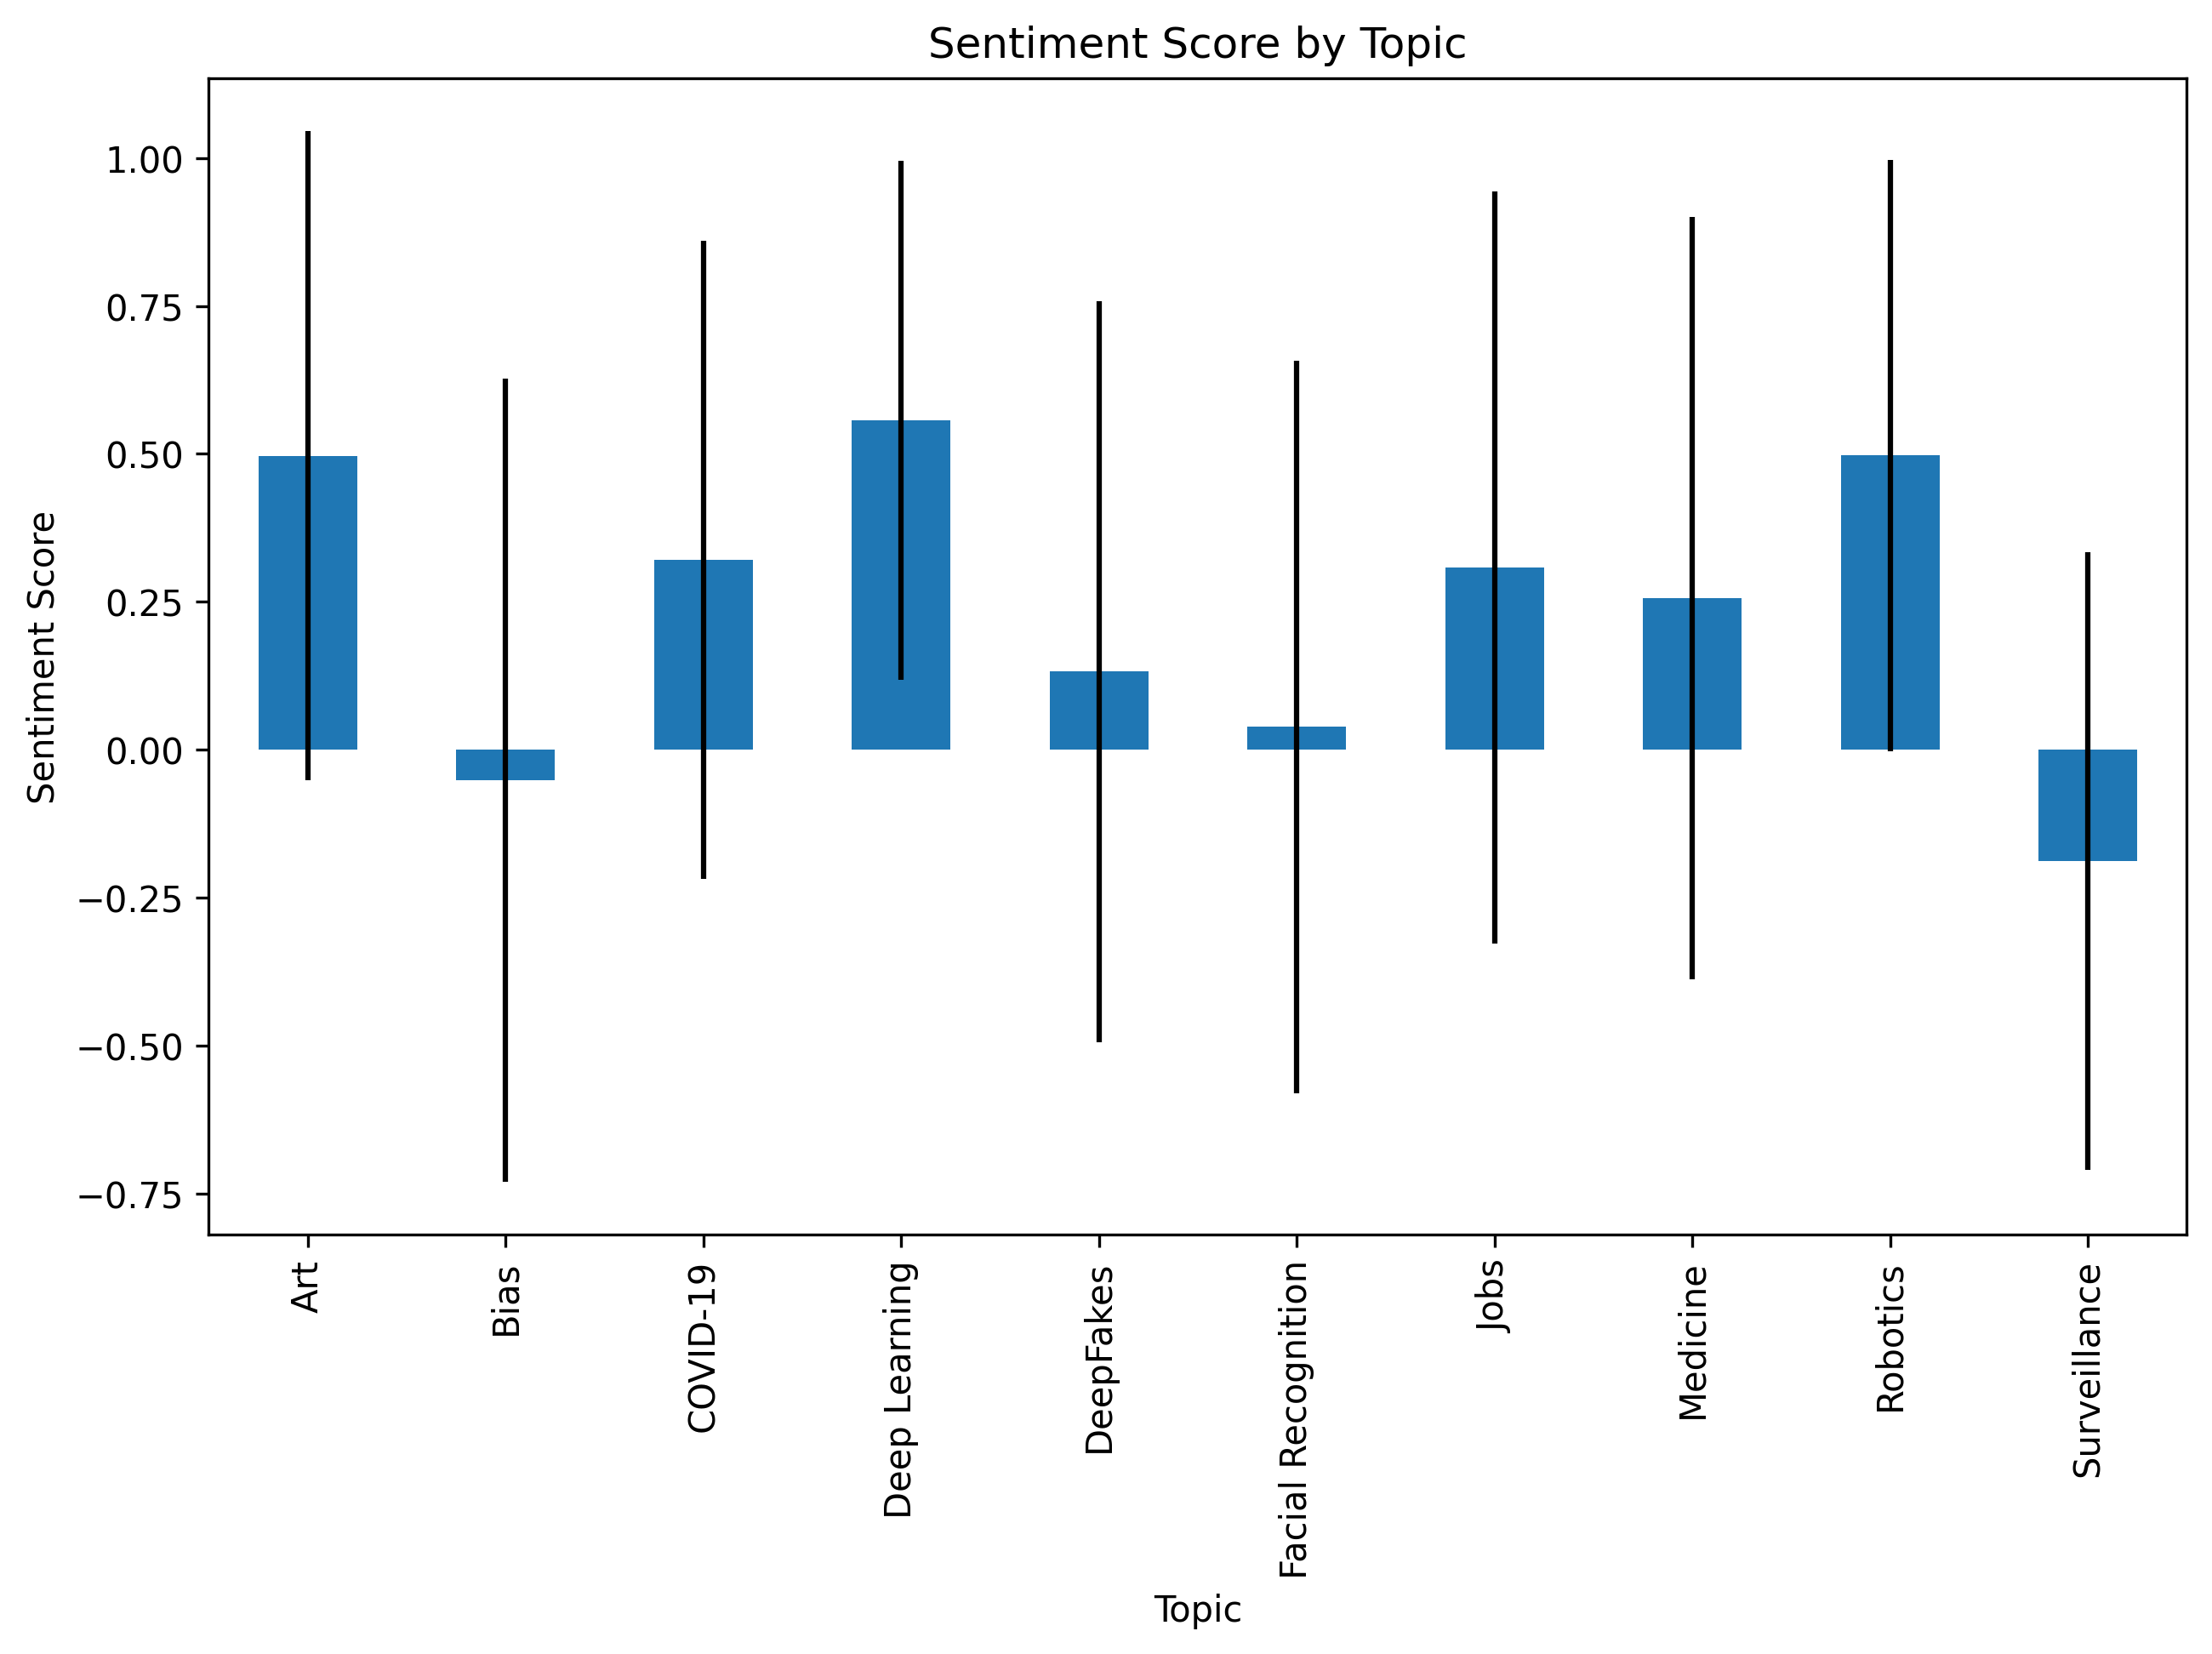

In [31]:
topic_df = df[df['topic']!='']
topic_df = topic_df.groupby("topic").agg([np.mean, np.std]) 
topic_df = topic_df['sentiment'] 

plt.figure(figsize=(10, 6), dpi=300)
ax = plt.gca()
topic_df.plot(kind="bar", y="mean", legend=False,  yerr="std", ax=ax, 
              title='Sentiment Score by Topic', xlabel='Topic', ylabel='Sentiment Score')
plt.savefig(plots_dir / 'sentiment_by_topic.png', bbox_inches='tight')
plt.show()

In [32]:
categories = df['category'].unique()

In [33]:
cfd = nltk.ConditionalFreqDist(
    (article[2], word.lower())
    for article in all_articles
    for word in nltk.tokenize.word_tokenize(article[-3]))
modals = ['ai',
 'bias',
 'neural',
 'robot',
 'artificial',
 'facial']
cfd.tabulate(categories, samples=modals)

                                                      ai       bias     neural      robot artificial     facial 
                          Advances & Business        768         31         94        122        151         70 
                            Analysis & Policy        360         10          1          7         69         91 
                              Concerns & Hype        634         46         27         34        110        205 
Expert Opinions & Discussion within the field        305         11         14          7         58          7 
                                   Explainers        113         12         45          4         16          3 
                                  Mini Briefs        265         19          9         15         40         55 


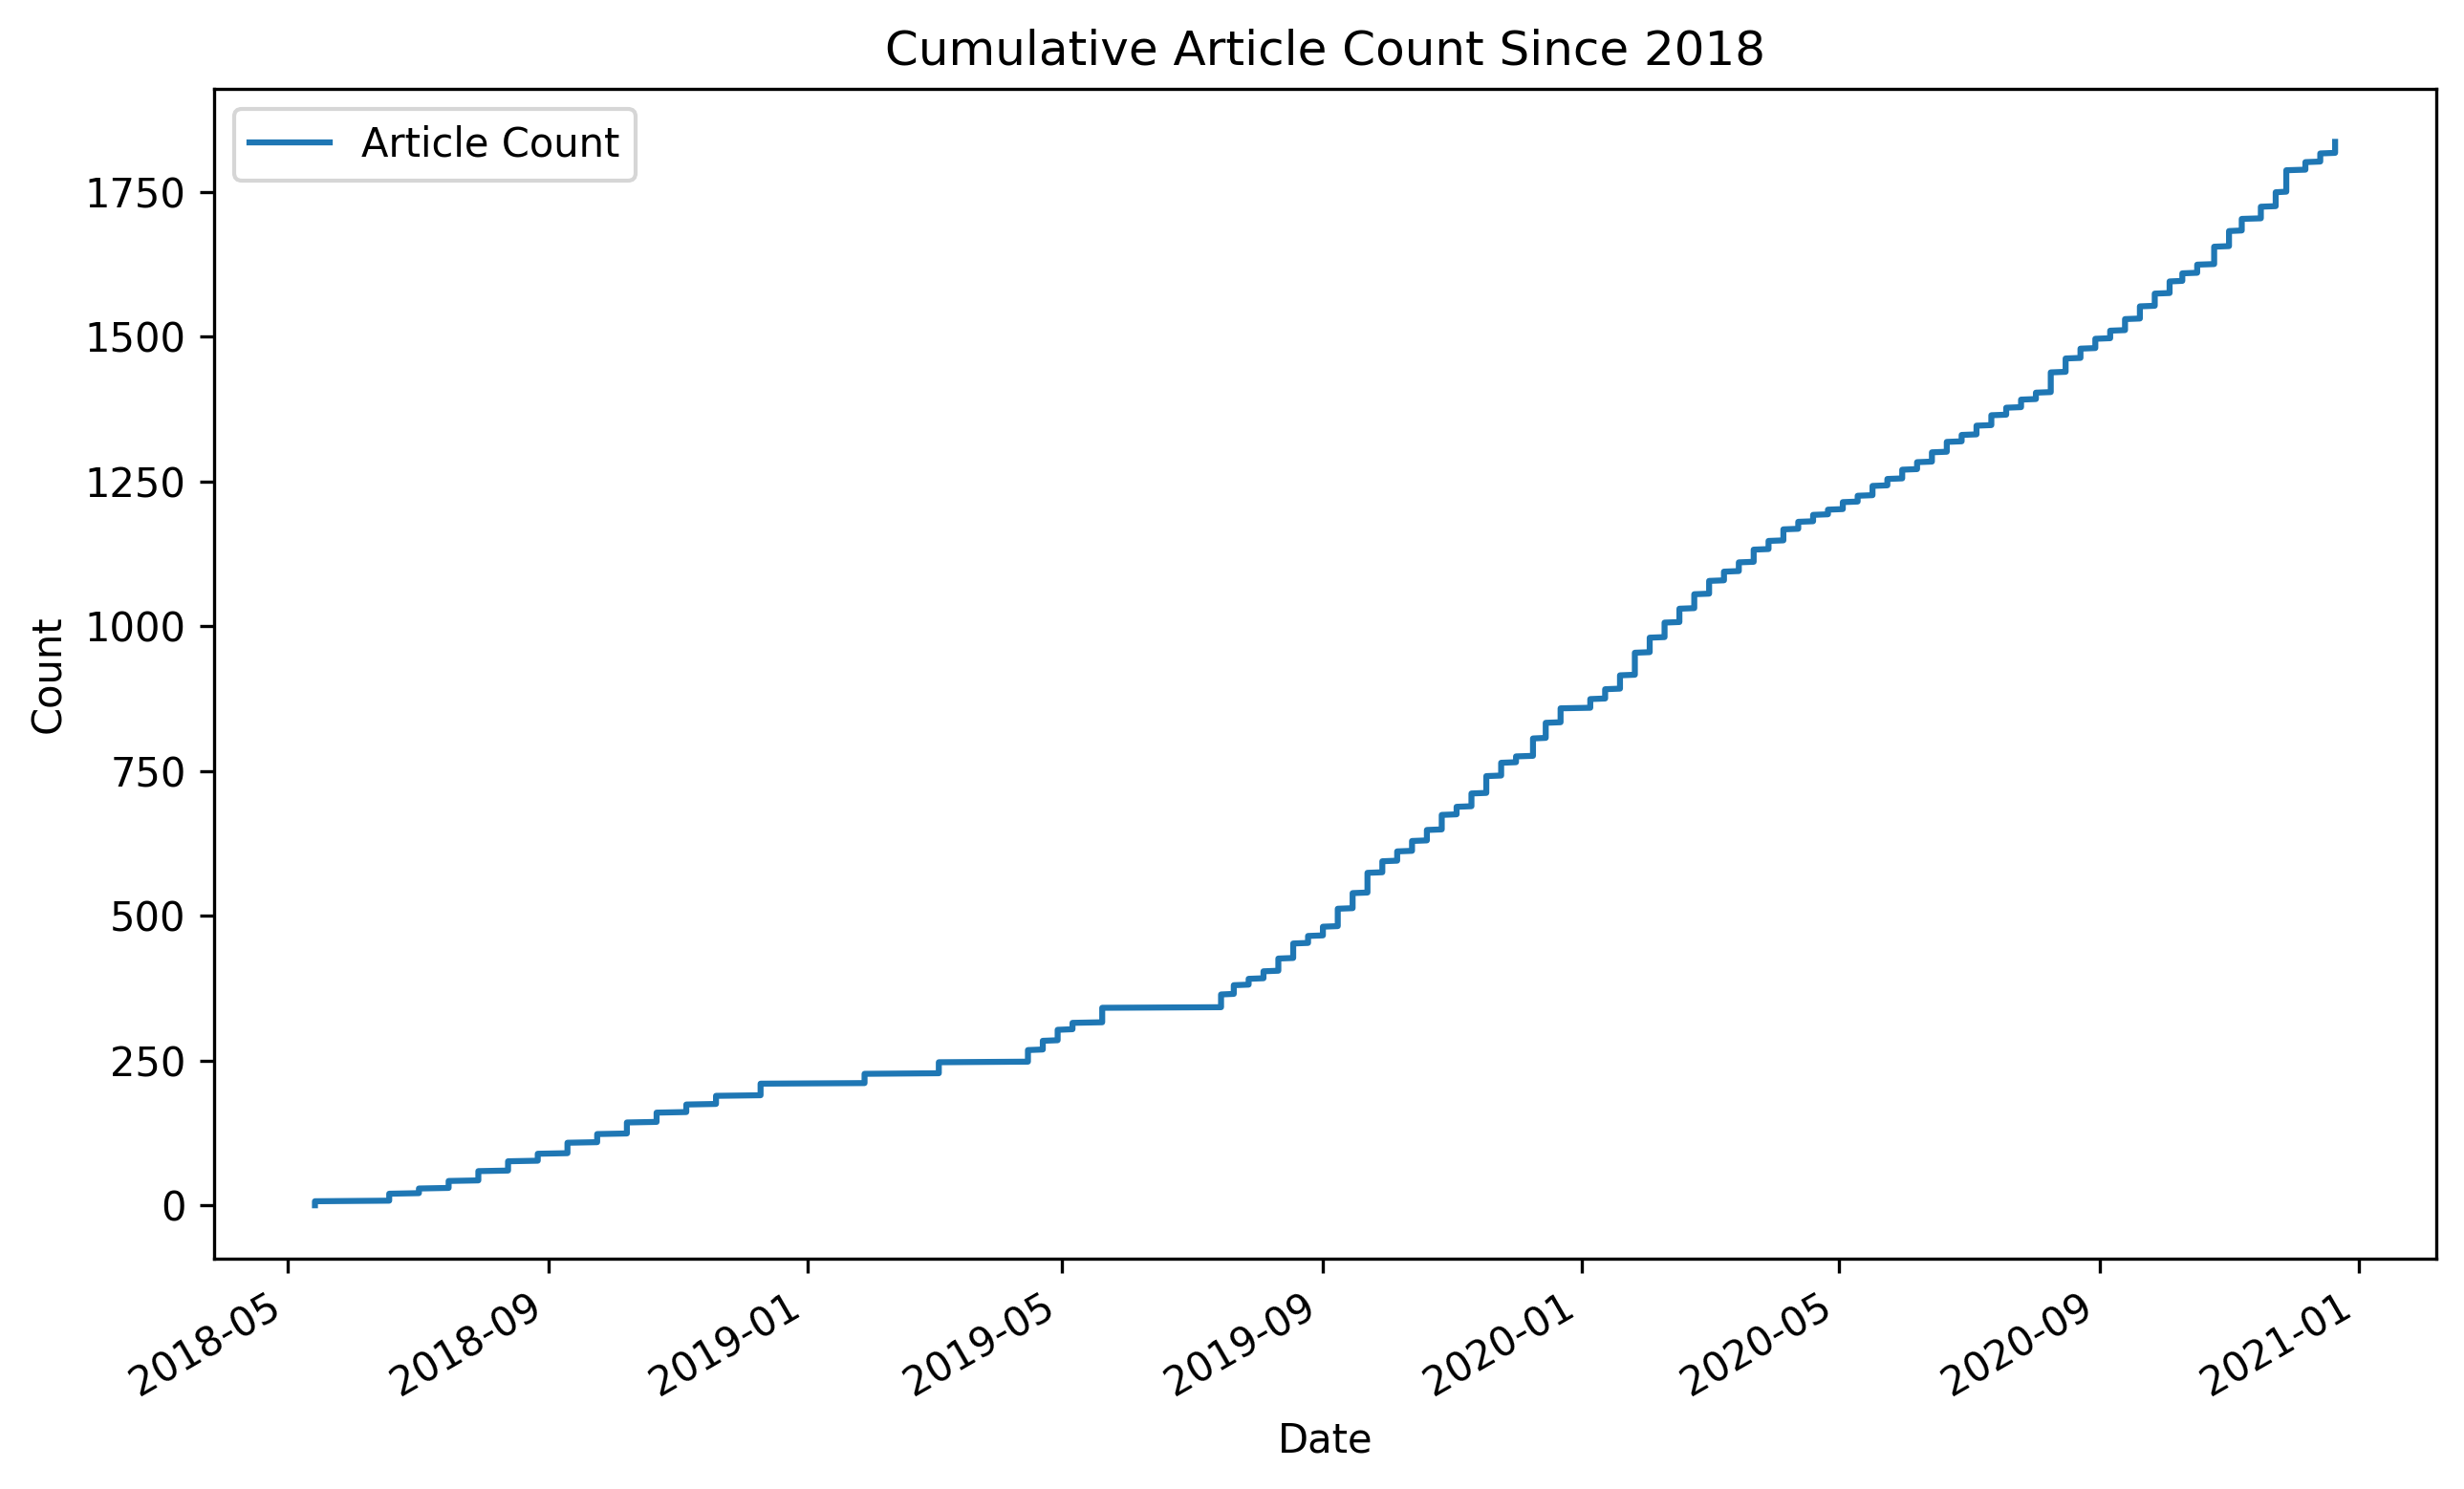

In [94]:
dicts = []
sorted_articles = sorted(all_articles, key = lambda x:x[1])
for i,article in enumerate(sorted_articles):
    x = article[1]
    d = {'Date': x, 'Article Count': i}
    dicts.append(d)
df_plot = pd.DataFrame(dicts)

plt.figure(figsize=(10, 6), dpi=300)
ax = plt.gca()
df_plot.plot(x='Date',y='Article Count', ax=ax, ylabel='Count', title='Cumulative Article Count Since 2018')
plt.savefig(plots_dir / 'article_count.png', bbox_inches='tight')
plt.show()

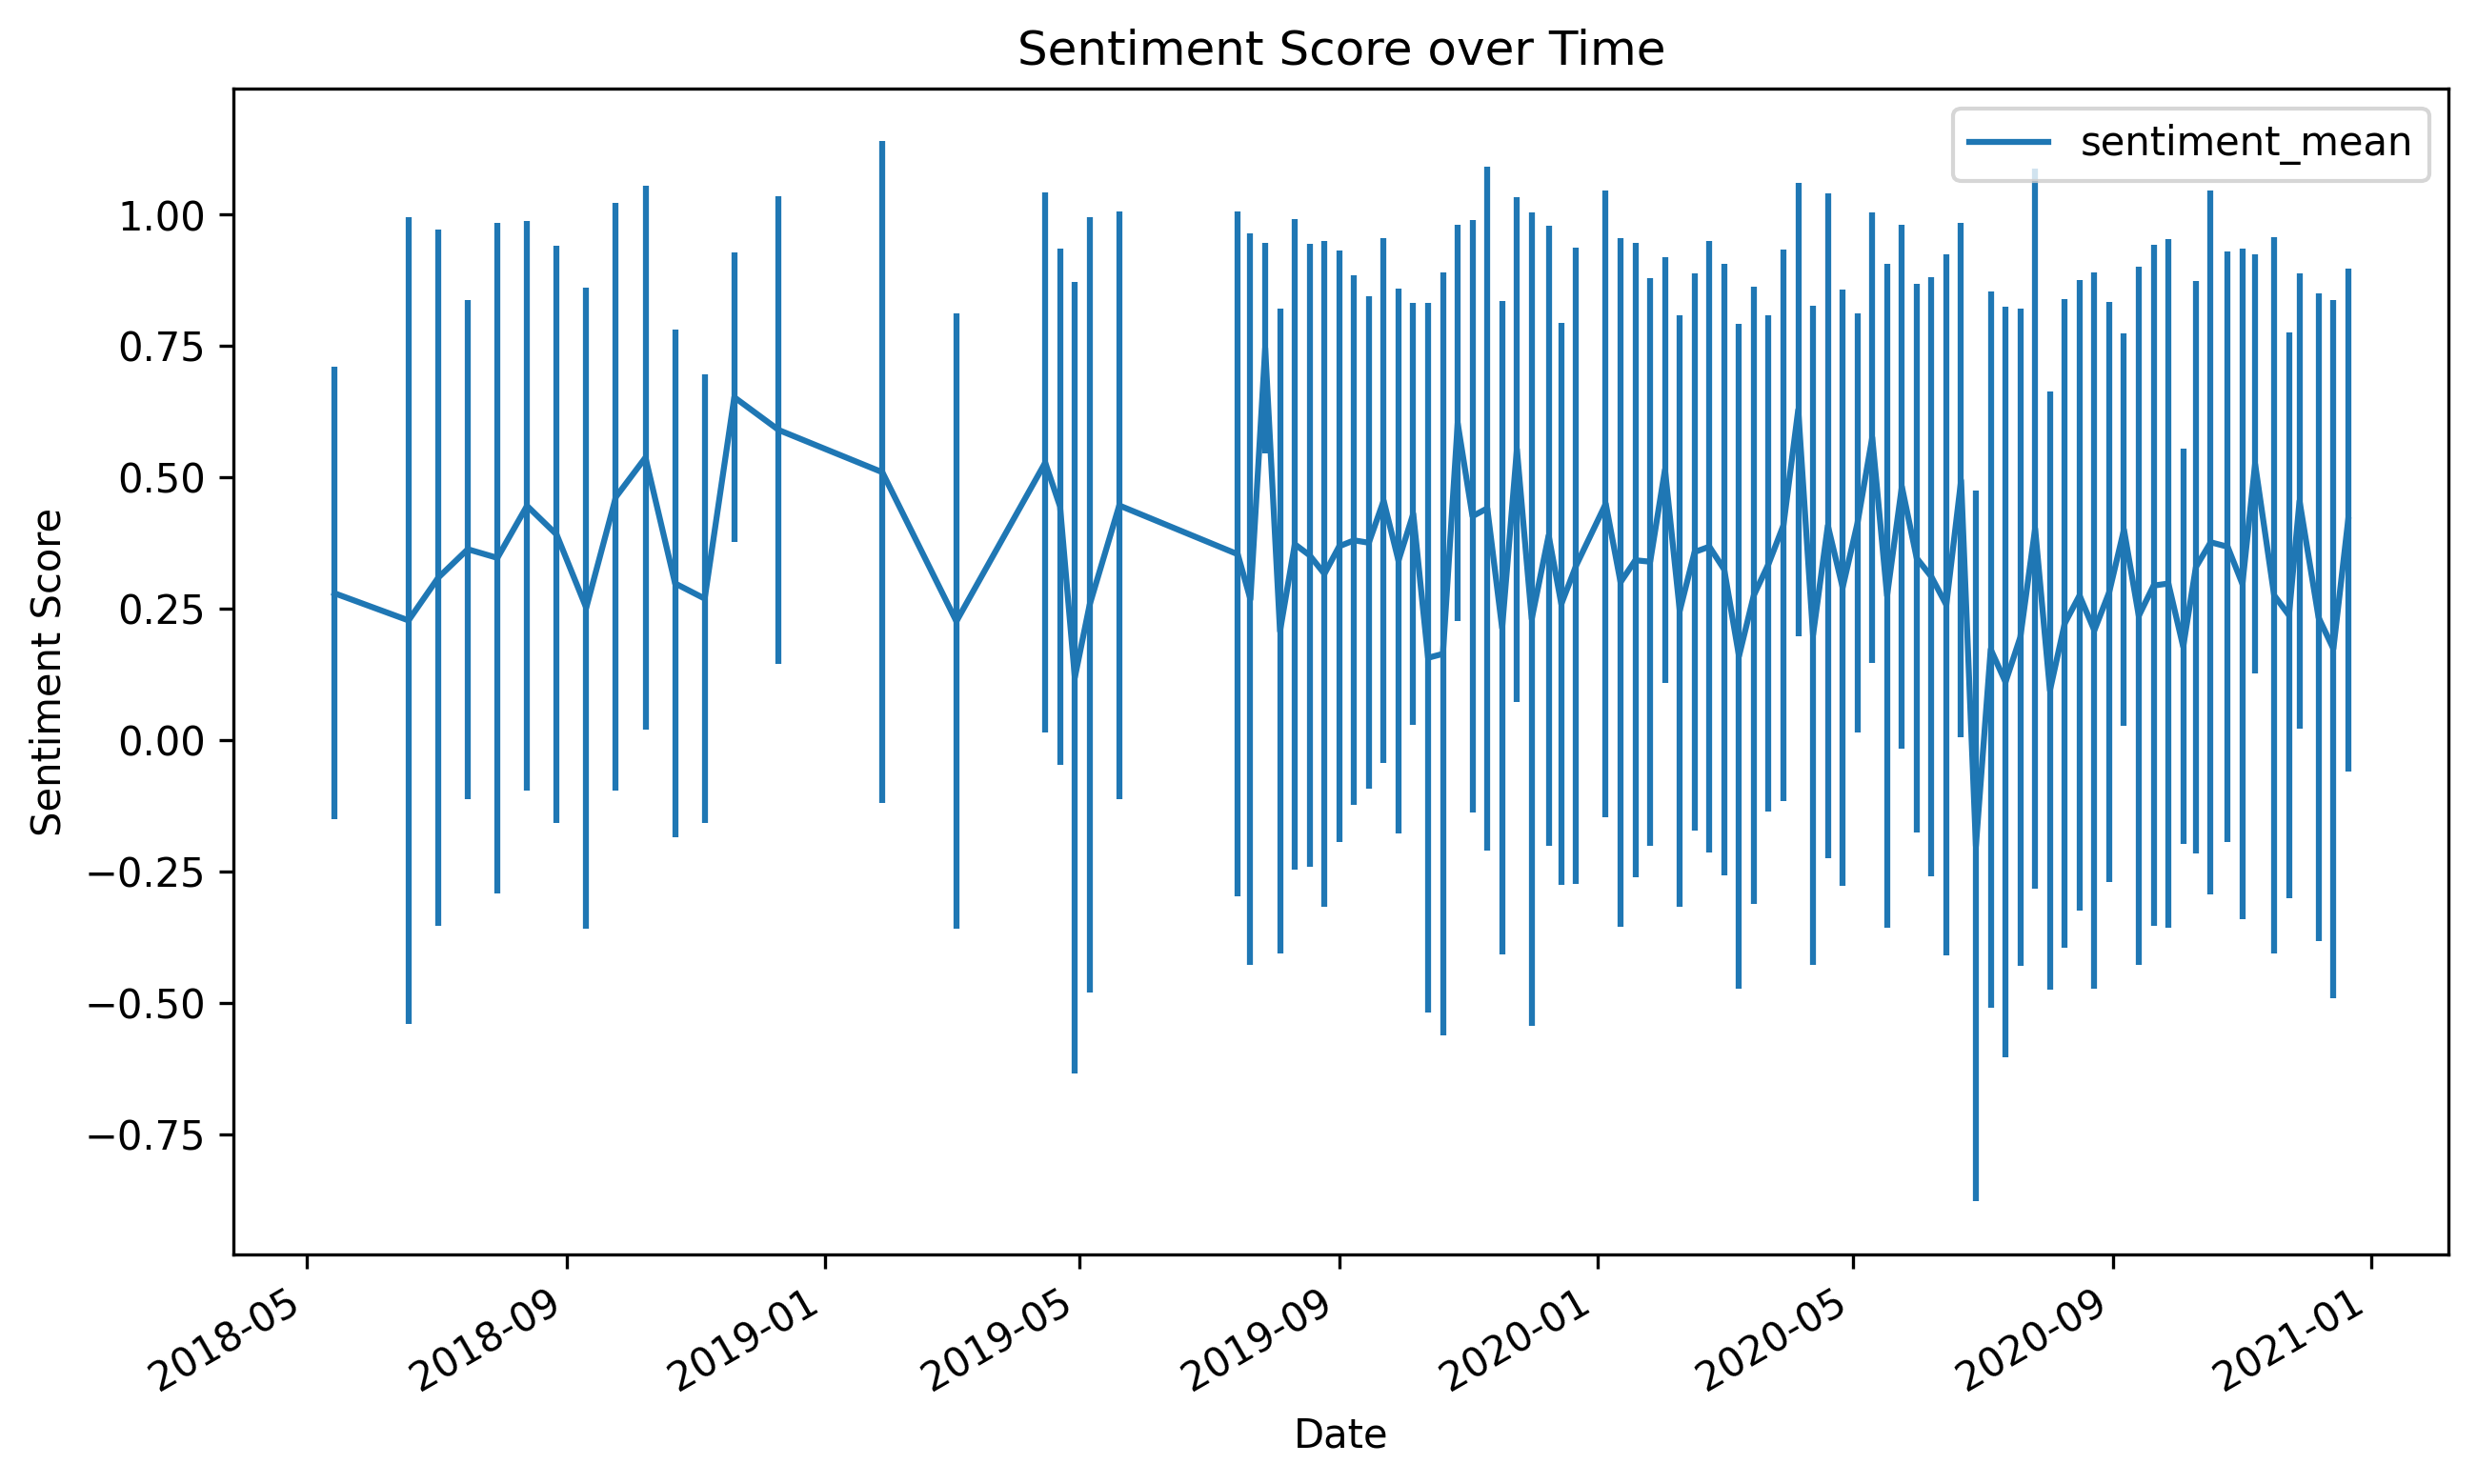

In [37]:
plot_df = pd.DataFrame()
plot_df['Date'] = sorted(df['digest_date'].unique())
plot_df['sentiment_std']= df.groupby('digest_date')['sentiment'].transform('std').unique()
plot_df['sentiment_mean'] = df.groupby('digest_date')['sentiment'].transform('mean').unique()

plt.figure(figsize=(10, 6), dpi=300)
ax = plt.gca()
plot_df.plot('Date', 'sentiment_mean', yerr='sentiment_std', ax=ax,
             ylabel='Sentiment Score', title='Sentiment Score over Time')
plt.savefig(plots_dir / 'sentiment_over_time.png', bbox_inches='tight')
plt.show()

<AxesSubplot:xlabel='edition', ylabel='sentiment'>

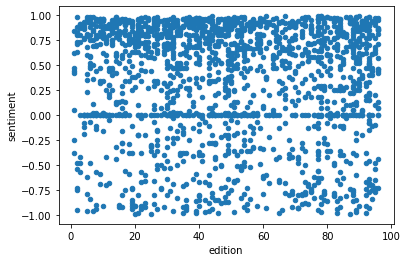

In [13]:
df.plot('edition','sentiment',kind='scatter')

In [ ]:
cfd = nltk.ConditionalFreqDist(
    (article[0], word.lower())
    for article in all_articles
    for word in nltk.tokenize.word_tokenize(article[3]))

In [128]:
def plot_trends(words_synonyms, display_name='', save_name=None, smooth_total=0, smooth_instance=4):
    synonyms = {}
    words = []
    for key, vals in words_synonyms.items():
        for val in vals:
            synonyms[val] = key
            words.append(val)
        words.append(key)
    
    dicts_total = []
    dicts_instance = []
    word_totals = {word : 0 for word in words}
    for x in sorted(df['edition'].unique()):
        word_counts = cfd[x]
        d_total = {'Date': edition_date_mapping[x]}
        d_instance = {'Date': edition_date_mapping[x]}

        for word in words:
            word_key = word
            if word in synonyms:
                word_key = synonyms[word]
            wc = word_counts[word]
            word_totals[word_key] += wc
            
            d_total[word_key] = word_totals[word_key]
            d_instance[word_key] = wc
        
        dicts_total.append(d_total)
        dicts_instance.append(d_instance)
    
    df_total_plot = pd.DataFrame(dicts_total)
    df_instance_plot = pd.DataFrame(dicts_instance)
    
    dates = df_total_plot['Date']
    if smooth_total > 0:
        df_total_plot = df_total_plot.rolling(window=smooth_total).mean()
        df_total_plot['Date'] = dates
    if smooth_instance > 0:
        df_instance_plot = df_instance_plot.rolling(window=smooth_instance).mean()
        df_instance_plot['Date'] = dates
    
    plt.figure(figsize=(10, 6), dpi=300)
    ax = plt.gca()
    df_total_plot.plot(x='Date', ylabel='Count', title=f'Cumulative Keyword Trends: {display_name}', ax=ax)
    if save_name is not None:
        plt.savefig(plots_dir / f'keyword_trends_cumulative_{save_name}.png', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 6), dpi=300)
    ax = plt.gca()
    df_instance_plot.plot(x='Date', ylabel='Count', title=f'Keyword Trends: {display_name}', ax=ax)
    if save_name is not None:
        plt.savefig(plots_dir / f'keyword_trends_{save_name}.png', bbox_inches='tight')
    plt.show()
    
    return df_total_plot, df_instance_plot

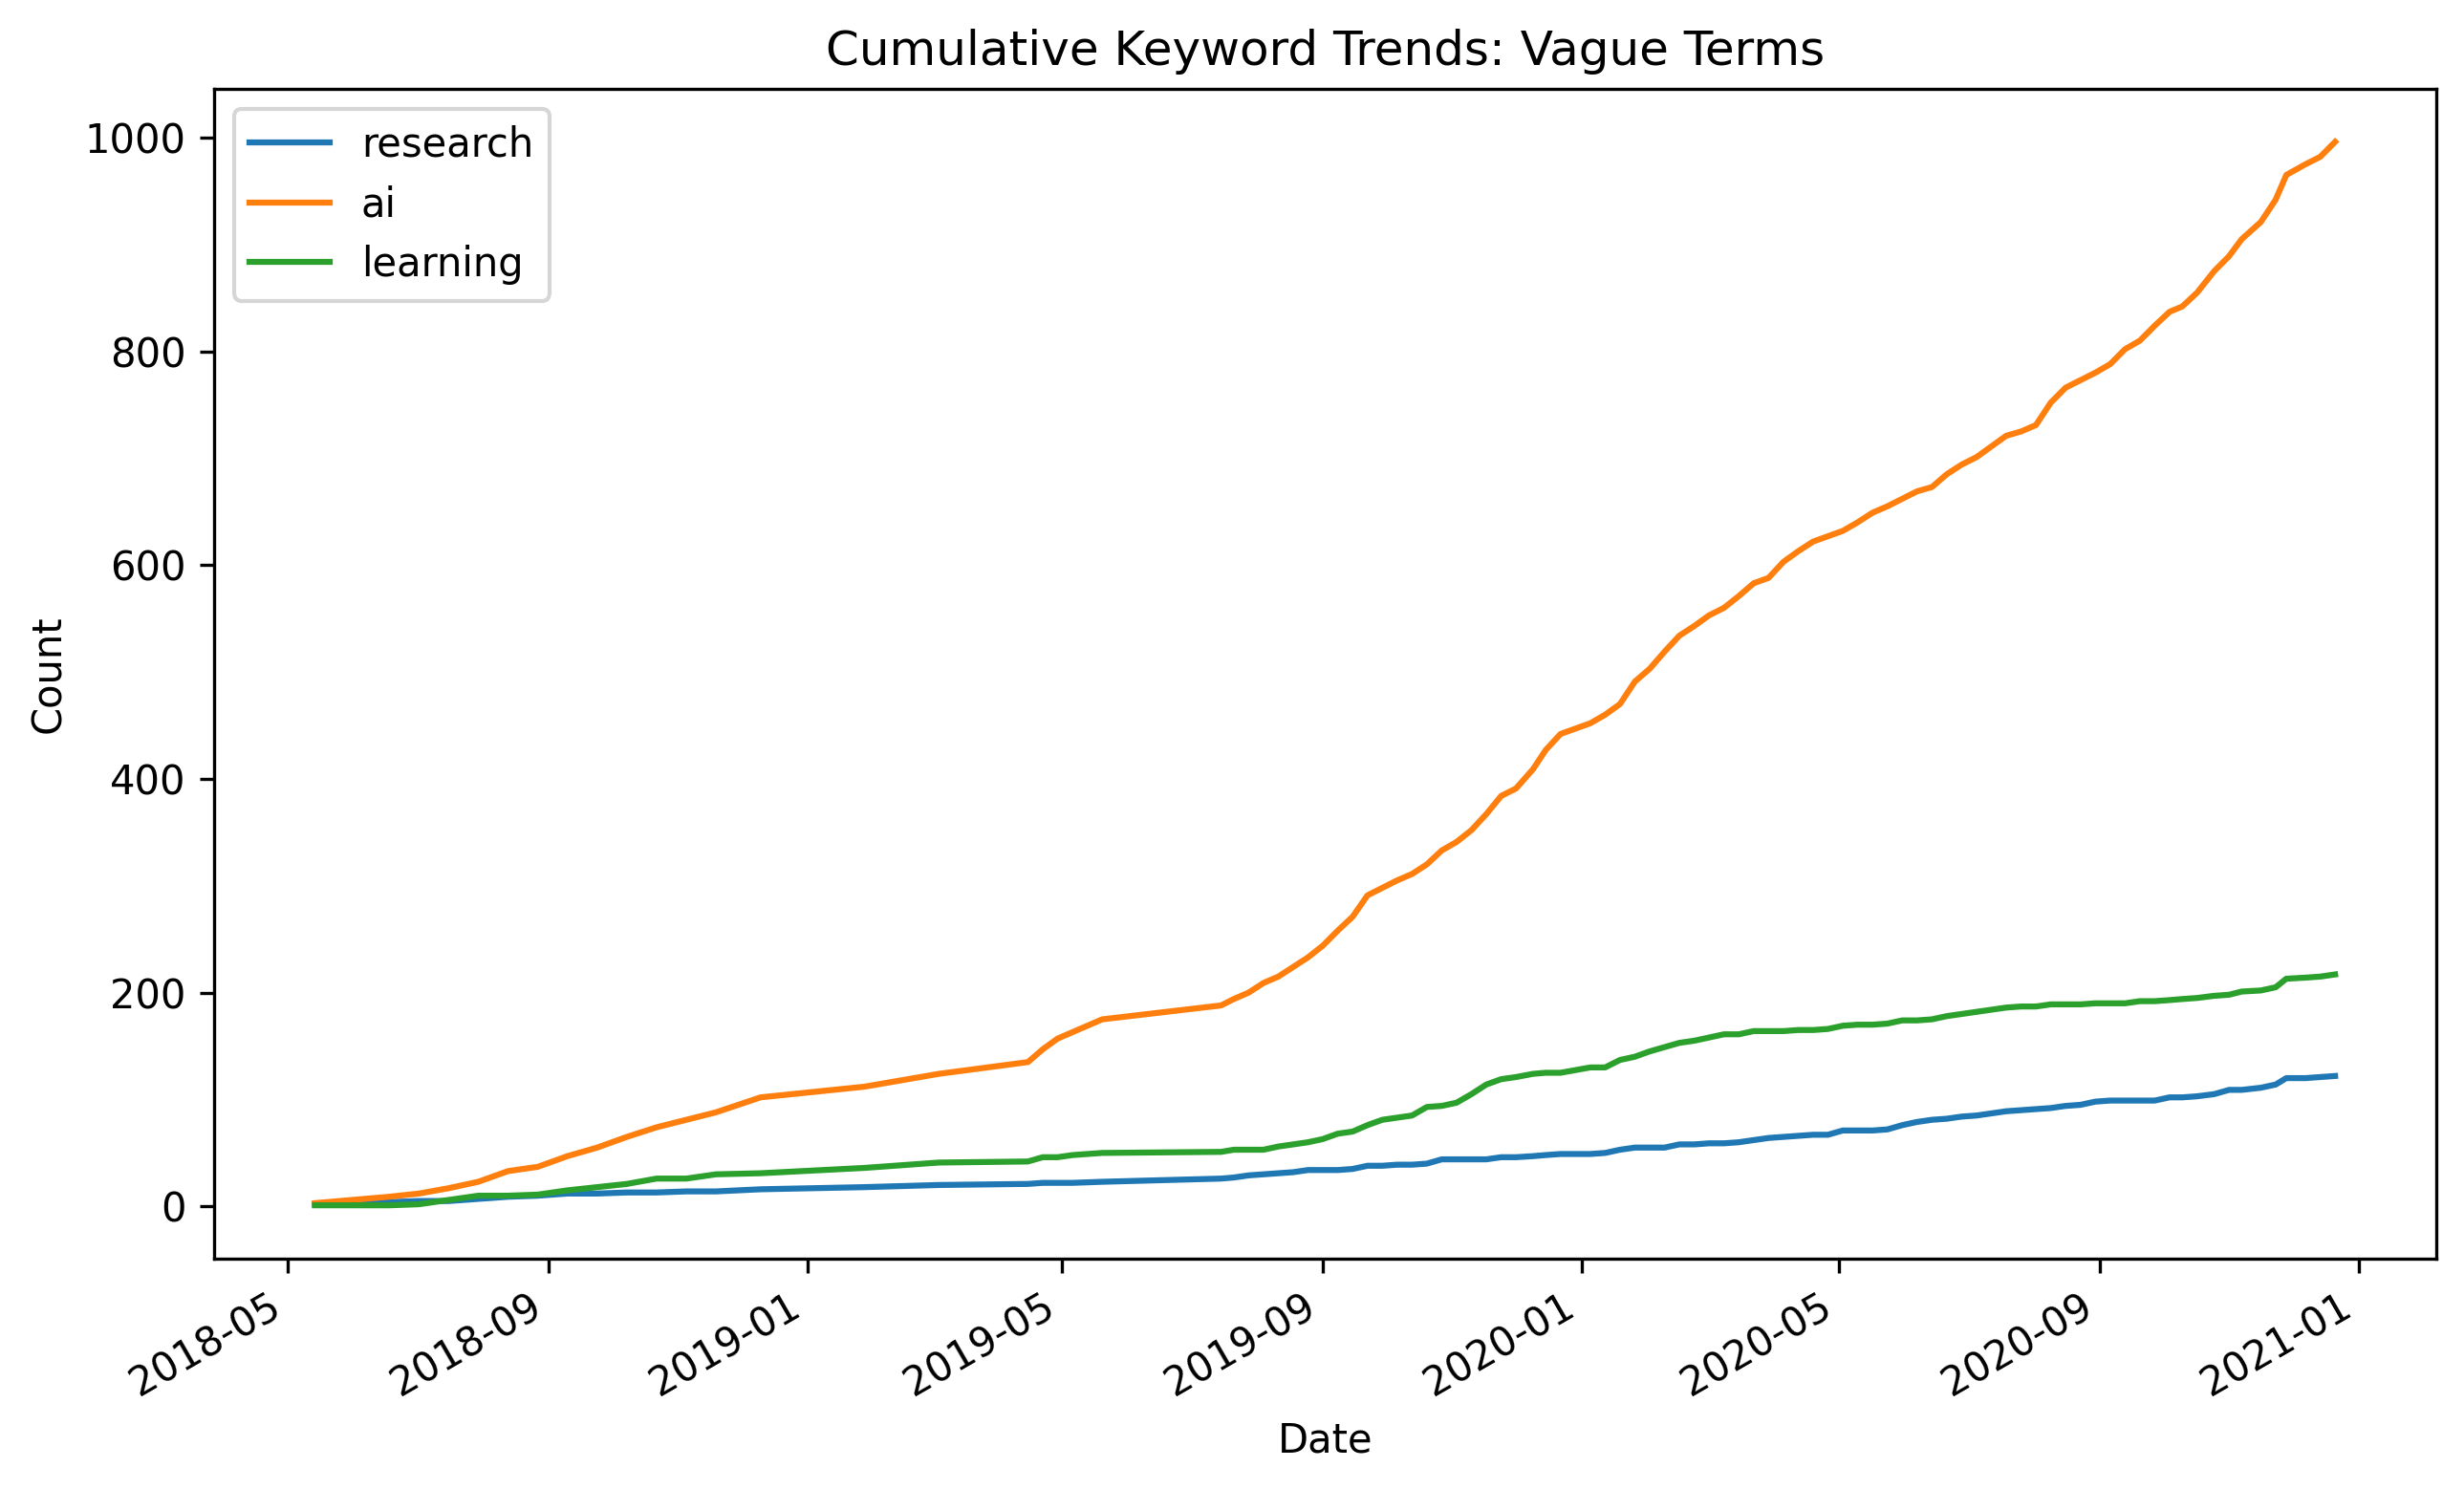

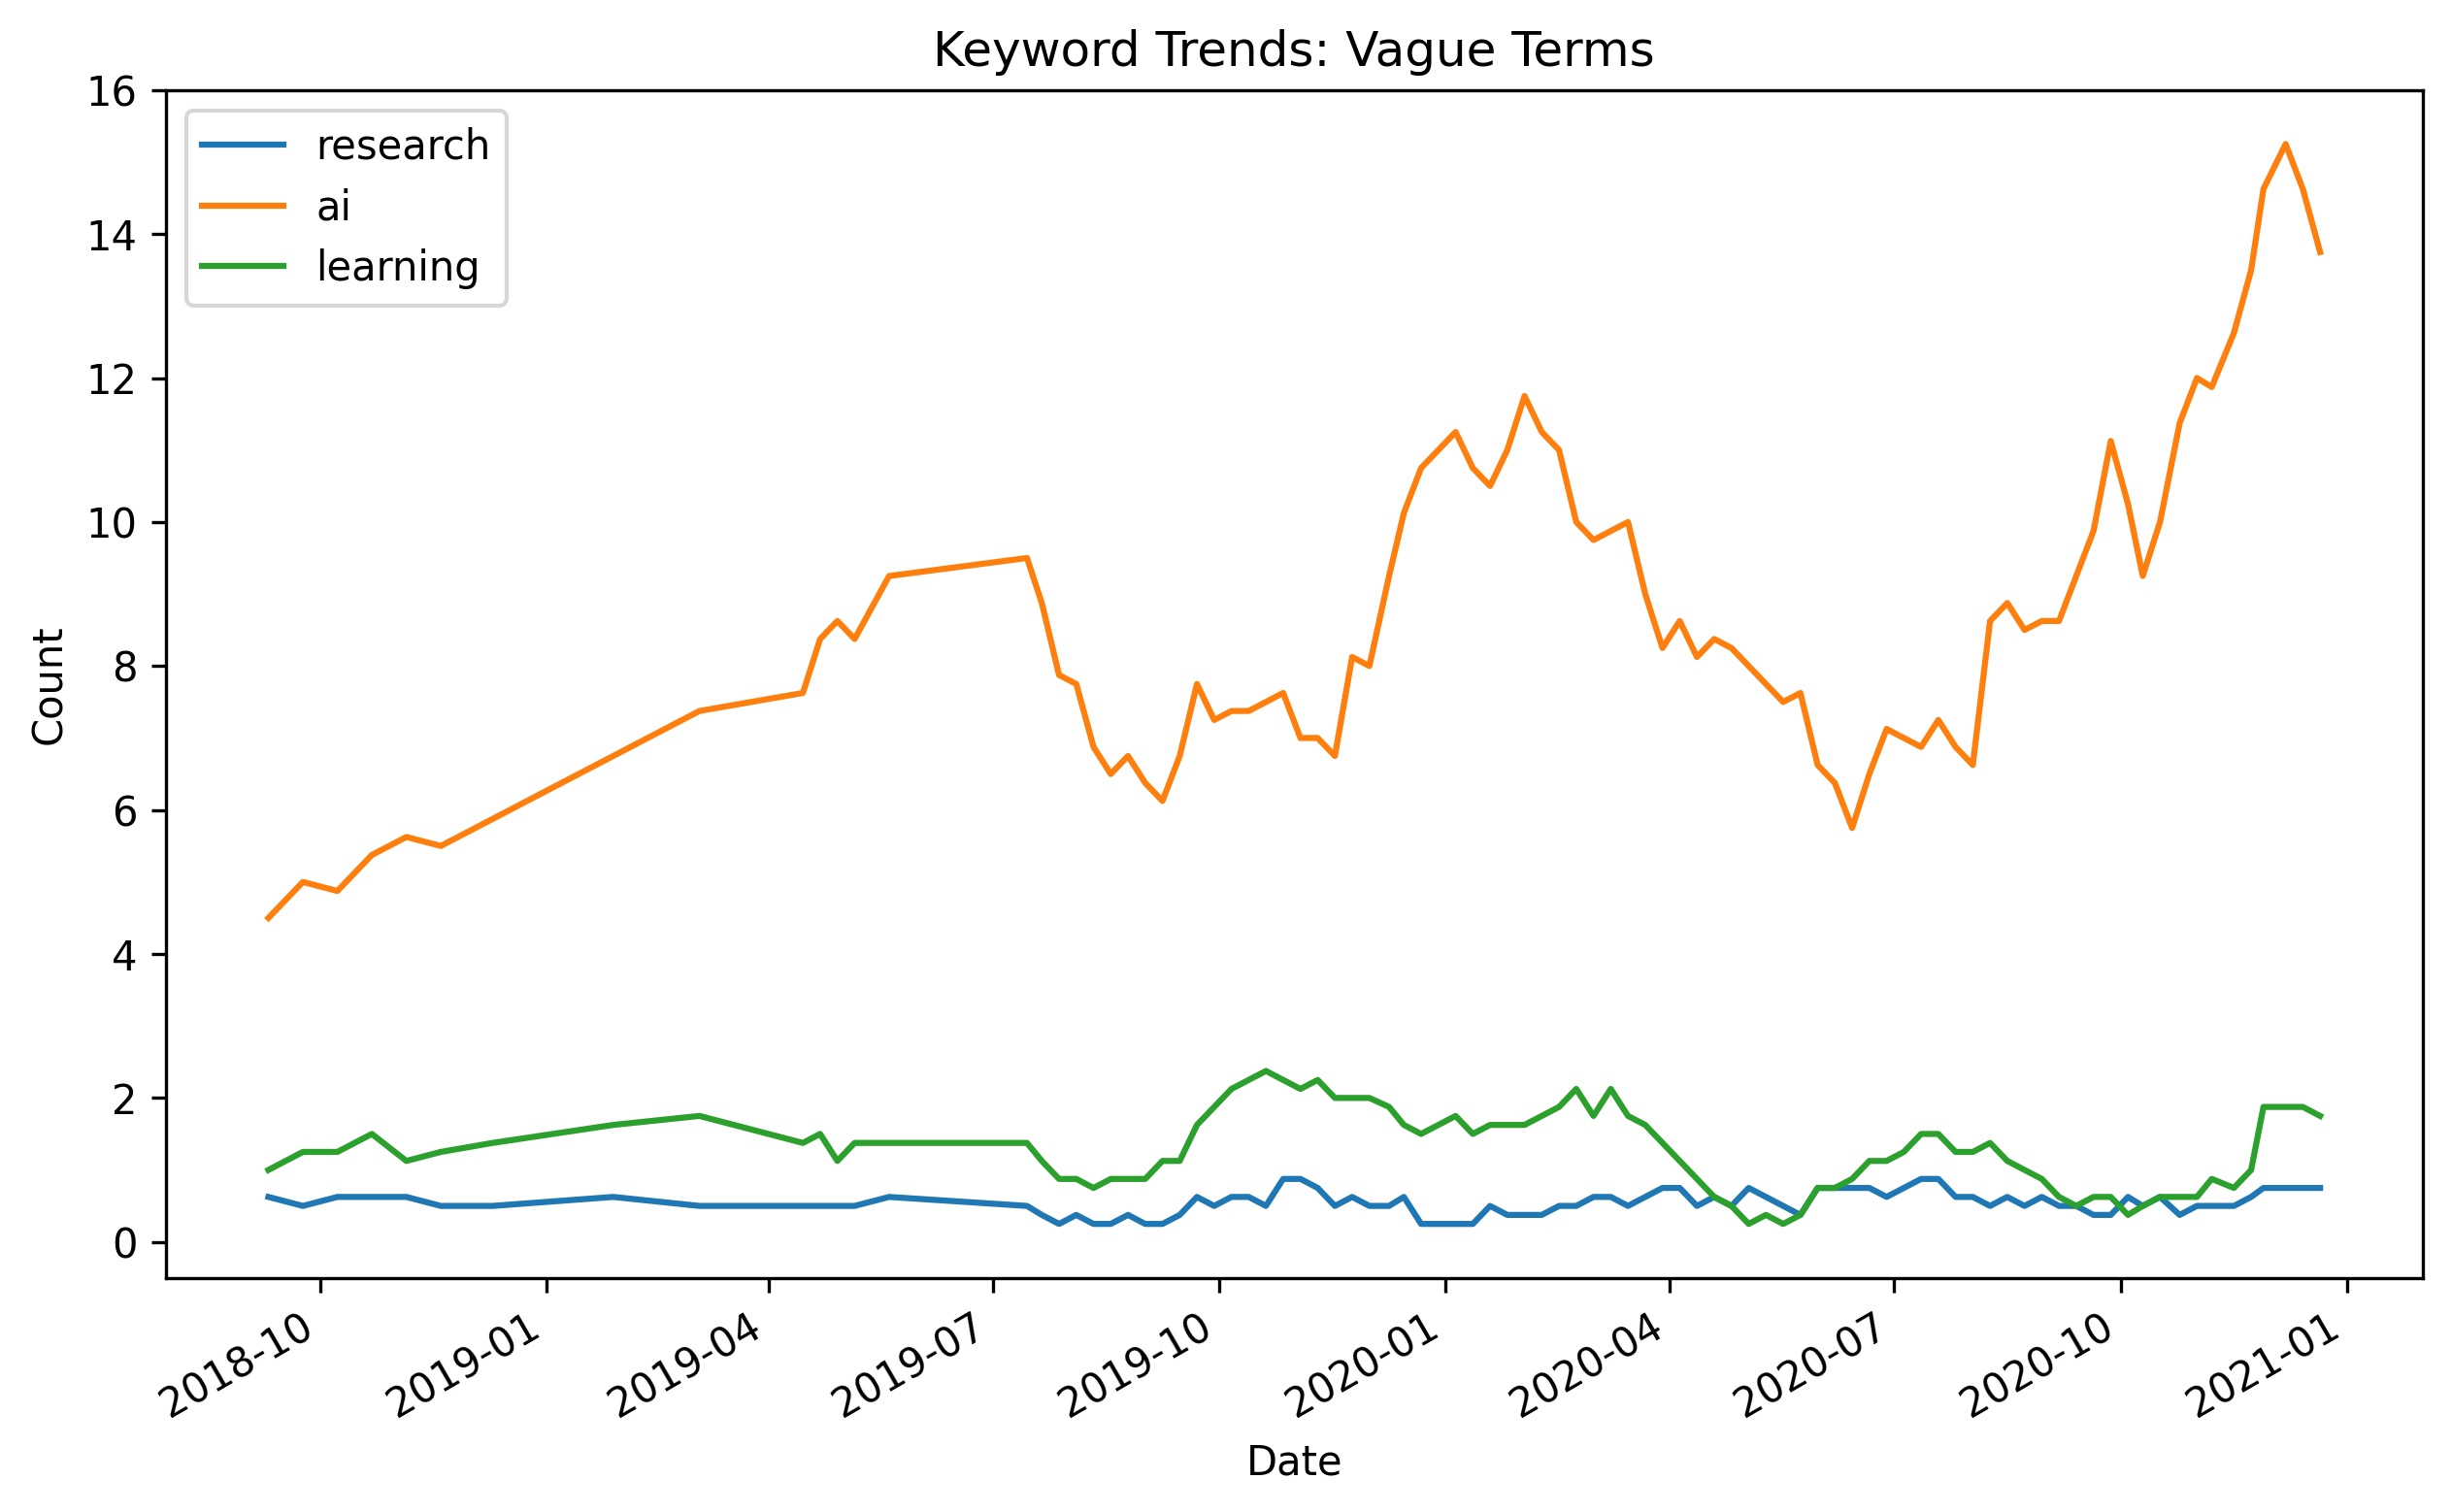

In [142]:
words_synonyms = {
    'research': ['researchers', 'academic', 'academics', 'academia', 'lab', 'labs', 'institutions'],
    'ai': ['artificial', 'intelligent', 'intelliegence', 'agi'],
    'learning': ['neural', 'deep', 'network', 'mlp', 'cnn', 'lstm', 'transformers', 'rnn', 'networks'],
}
_ = plot_trends(words_synonyms, display_name='Vague Terms', save_name='vague_terms')

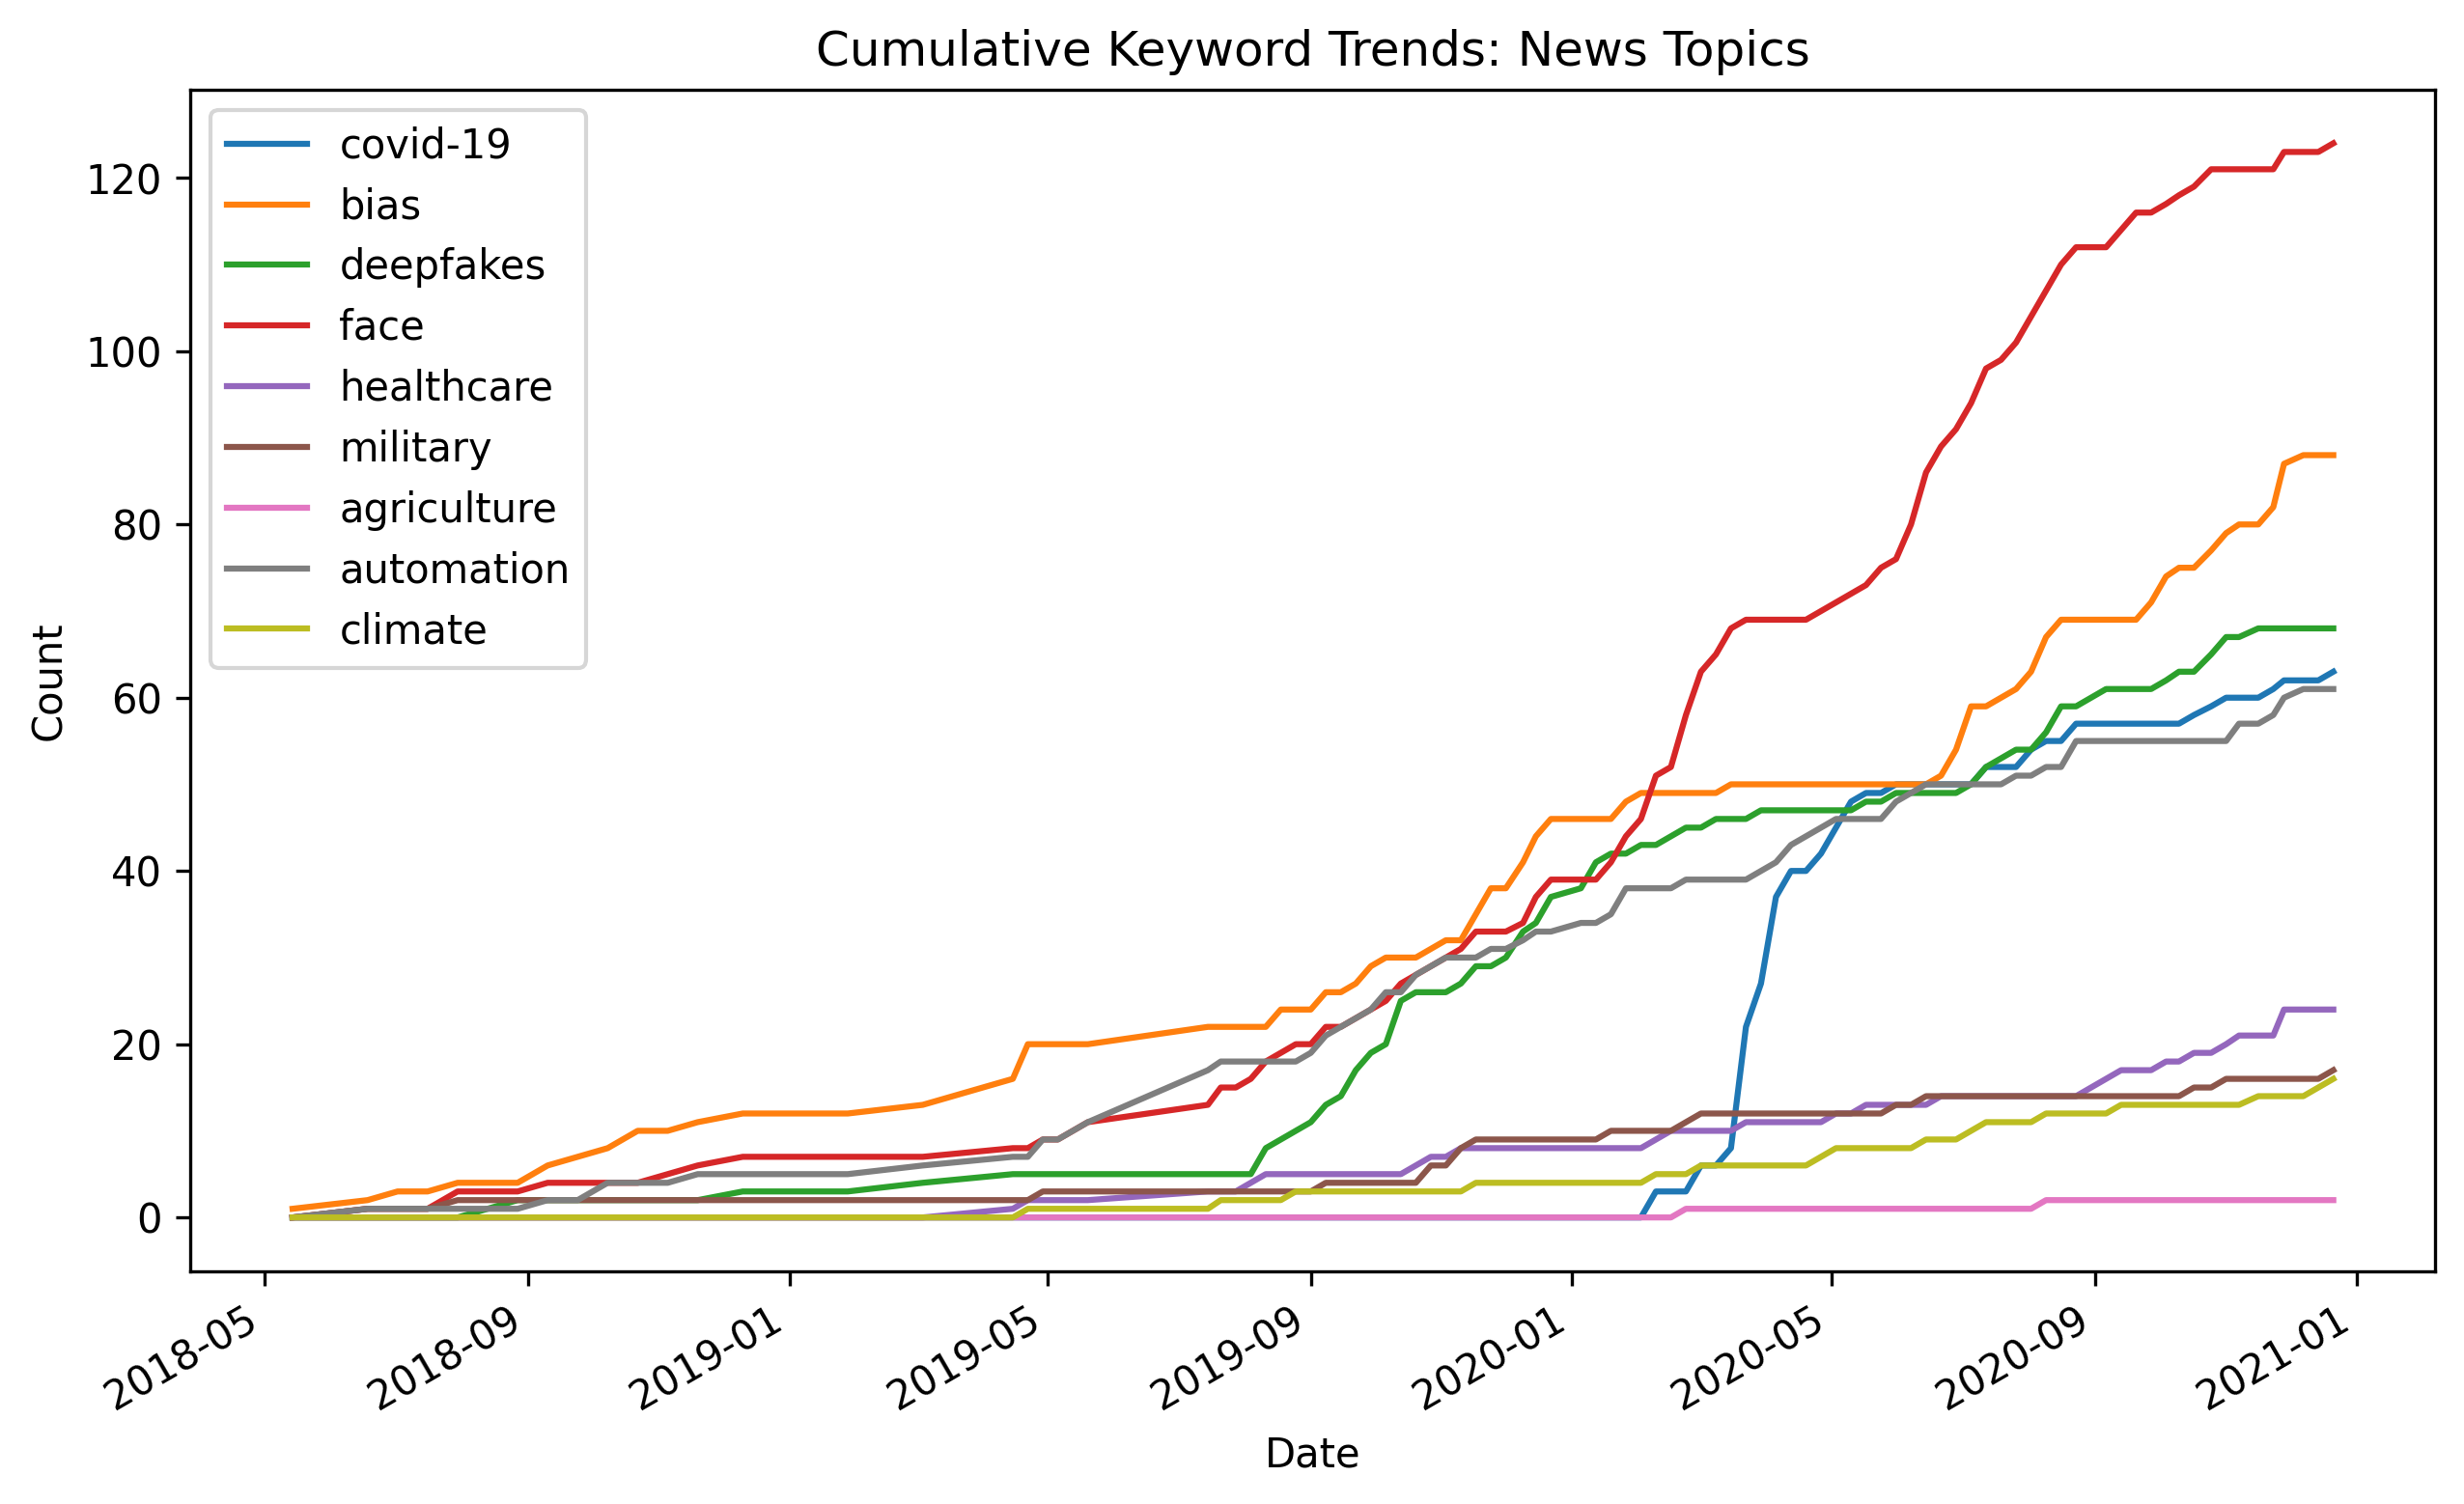

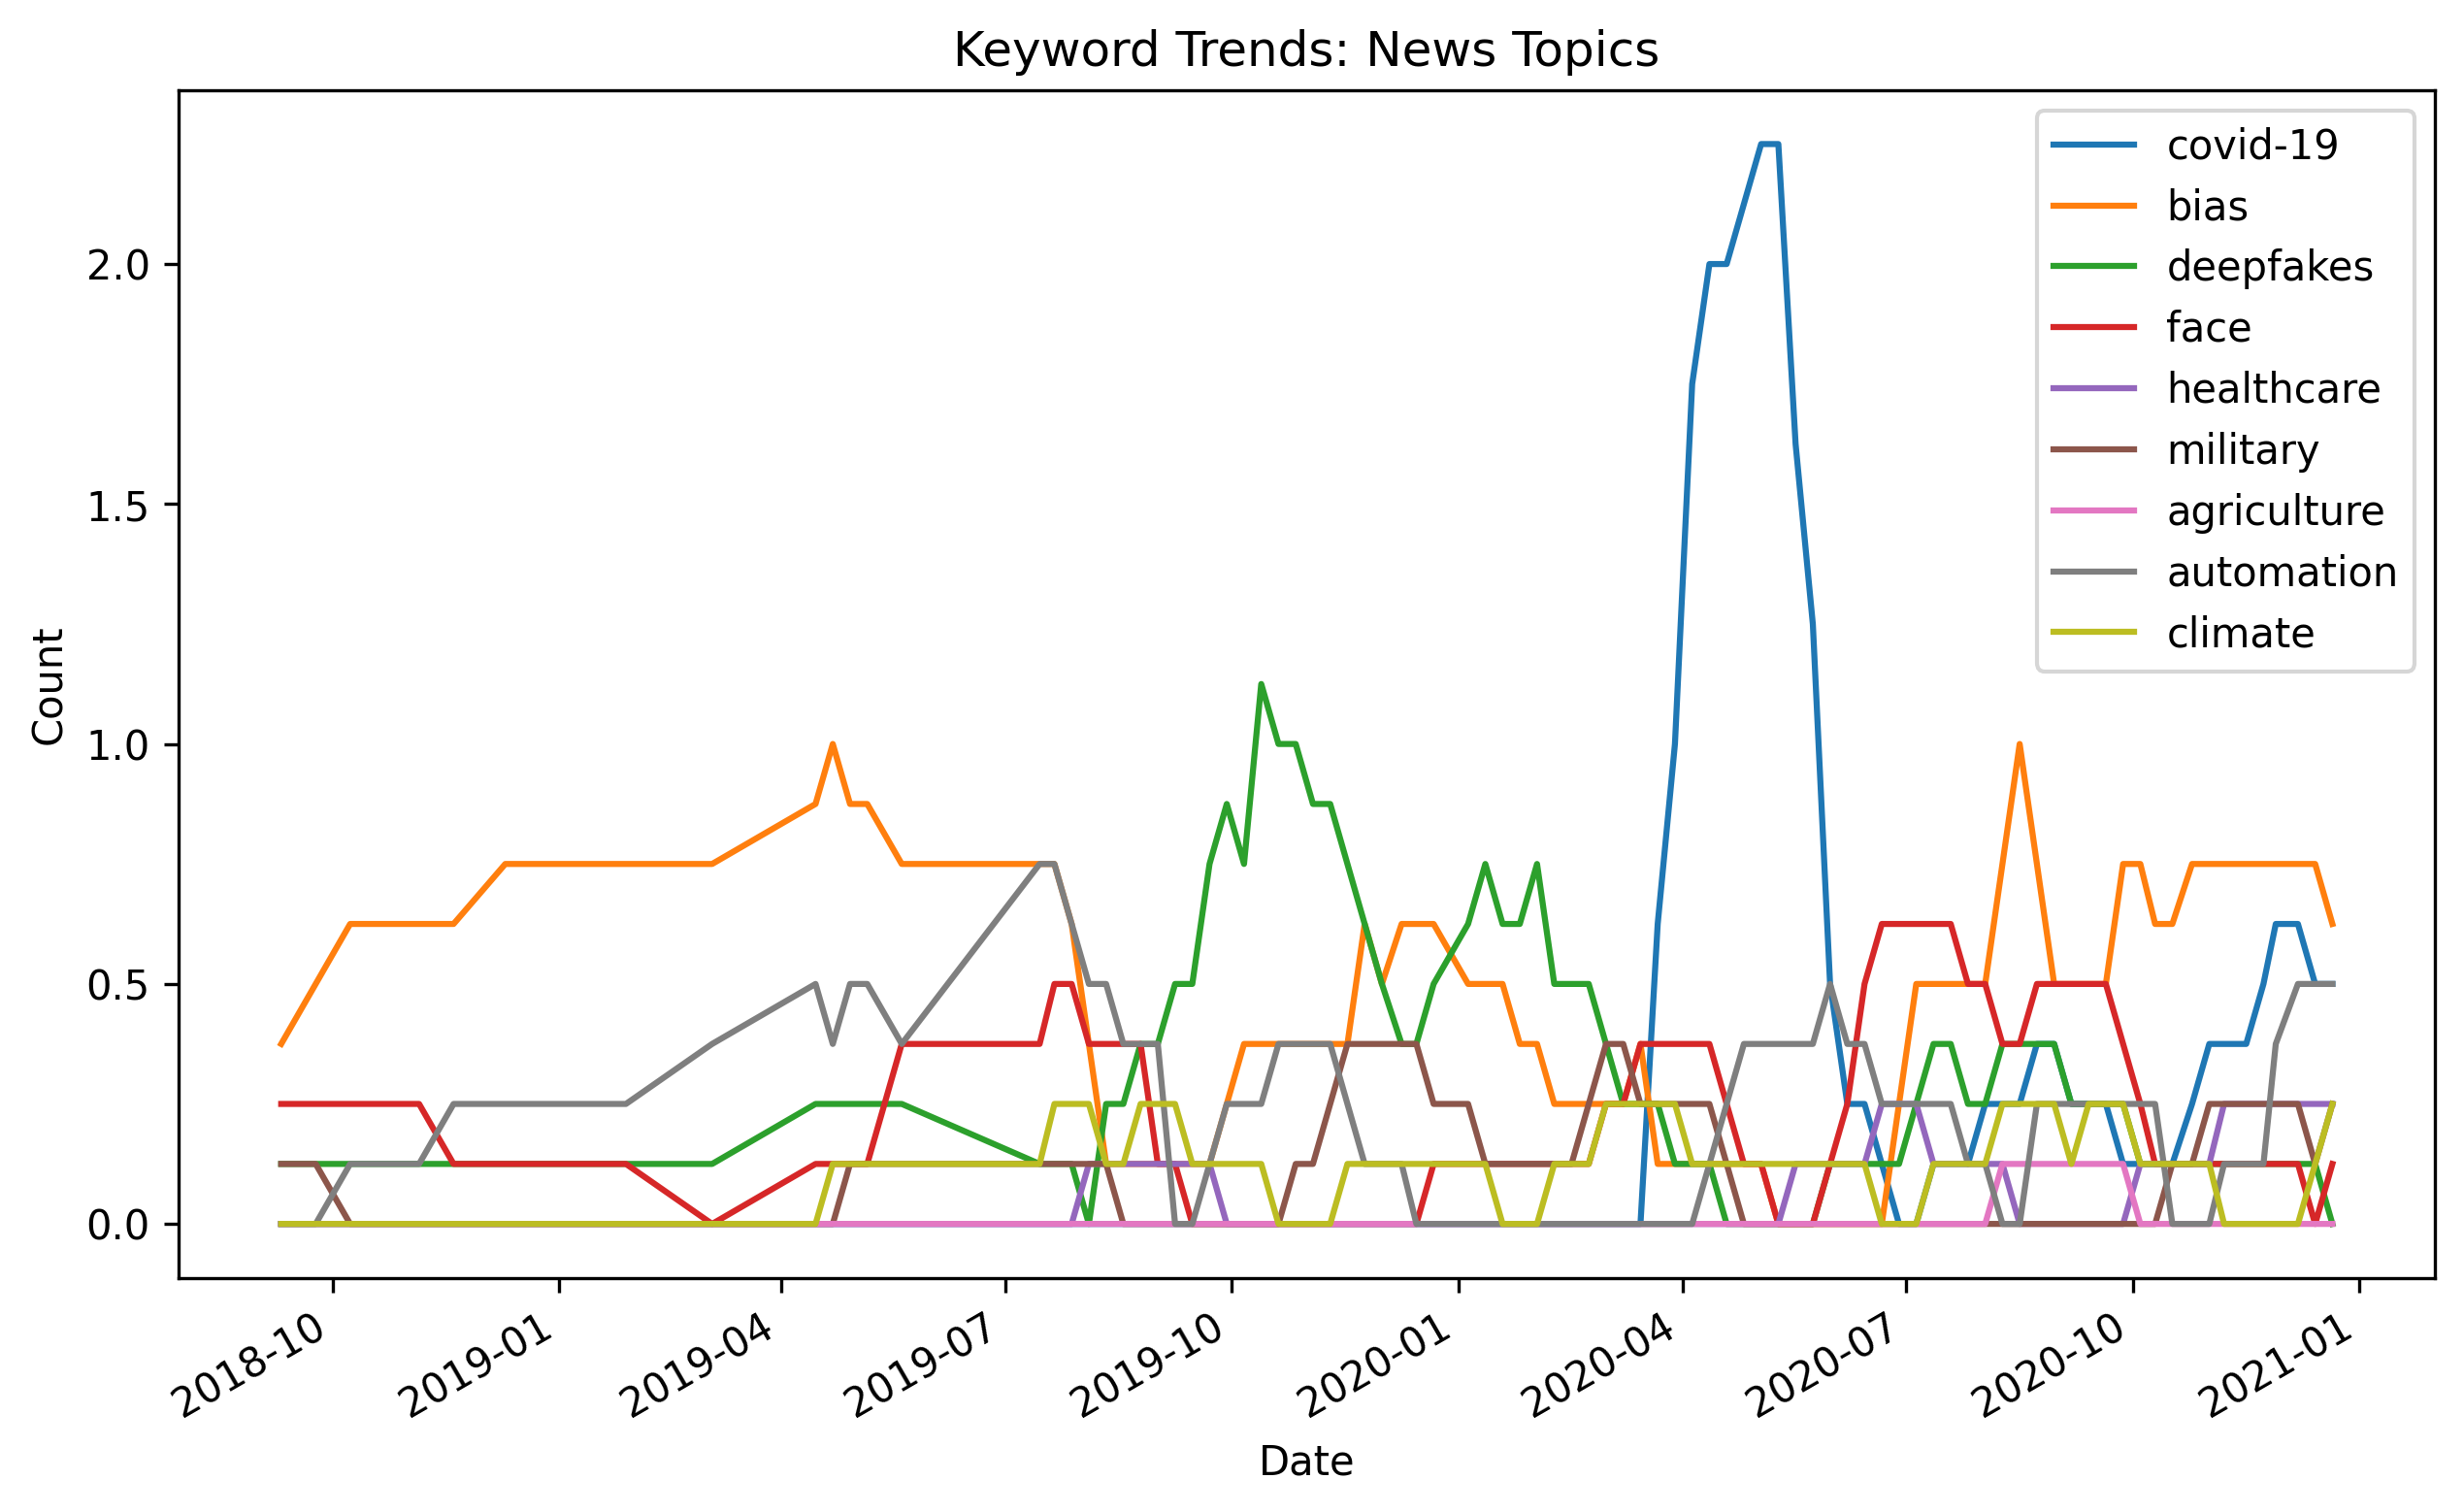

In [147]:
words_synonyms = {
    'covid-19': ['coronavirus', 'covid', 'mask', 'masks'],
    'bias': ['biased', 'racist', 'sexist', 'race', 'gender'],
    'deepfakes': ['deepfake', 'fake'],
    'face': ['facial', 'surveillance'],
    
    'healthcare': ['diagnose', 'medicine', 'hospital', 'nurse', 'medical', 'protein', 'drug', 'drugs'],
    'military': ['army', 'navy', 'weapon', 'weapons'],
    'agriculture': ['farm', 'farms'],
    'automation': ['jobs', 'job', 'displacement', 'disrupt', 'disruption', 'replace'],
    'climate': ['warming', 'emission', 'emissions', 'carbon', 'co2'],
}
    
_ = plot_trends(words_synonyms, display_name='News Topics', save_name='news_topics')

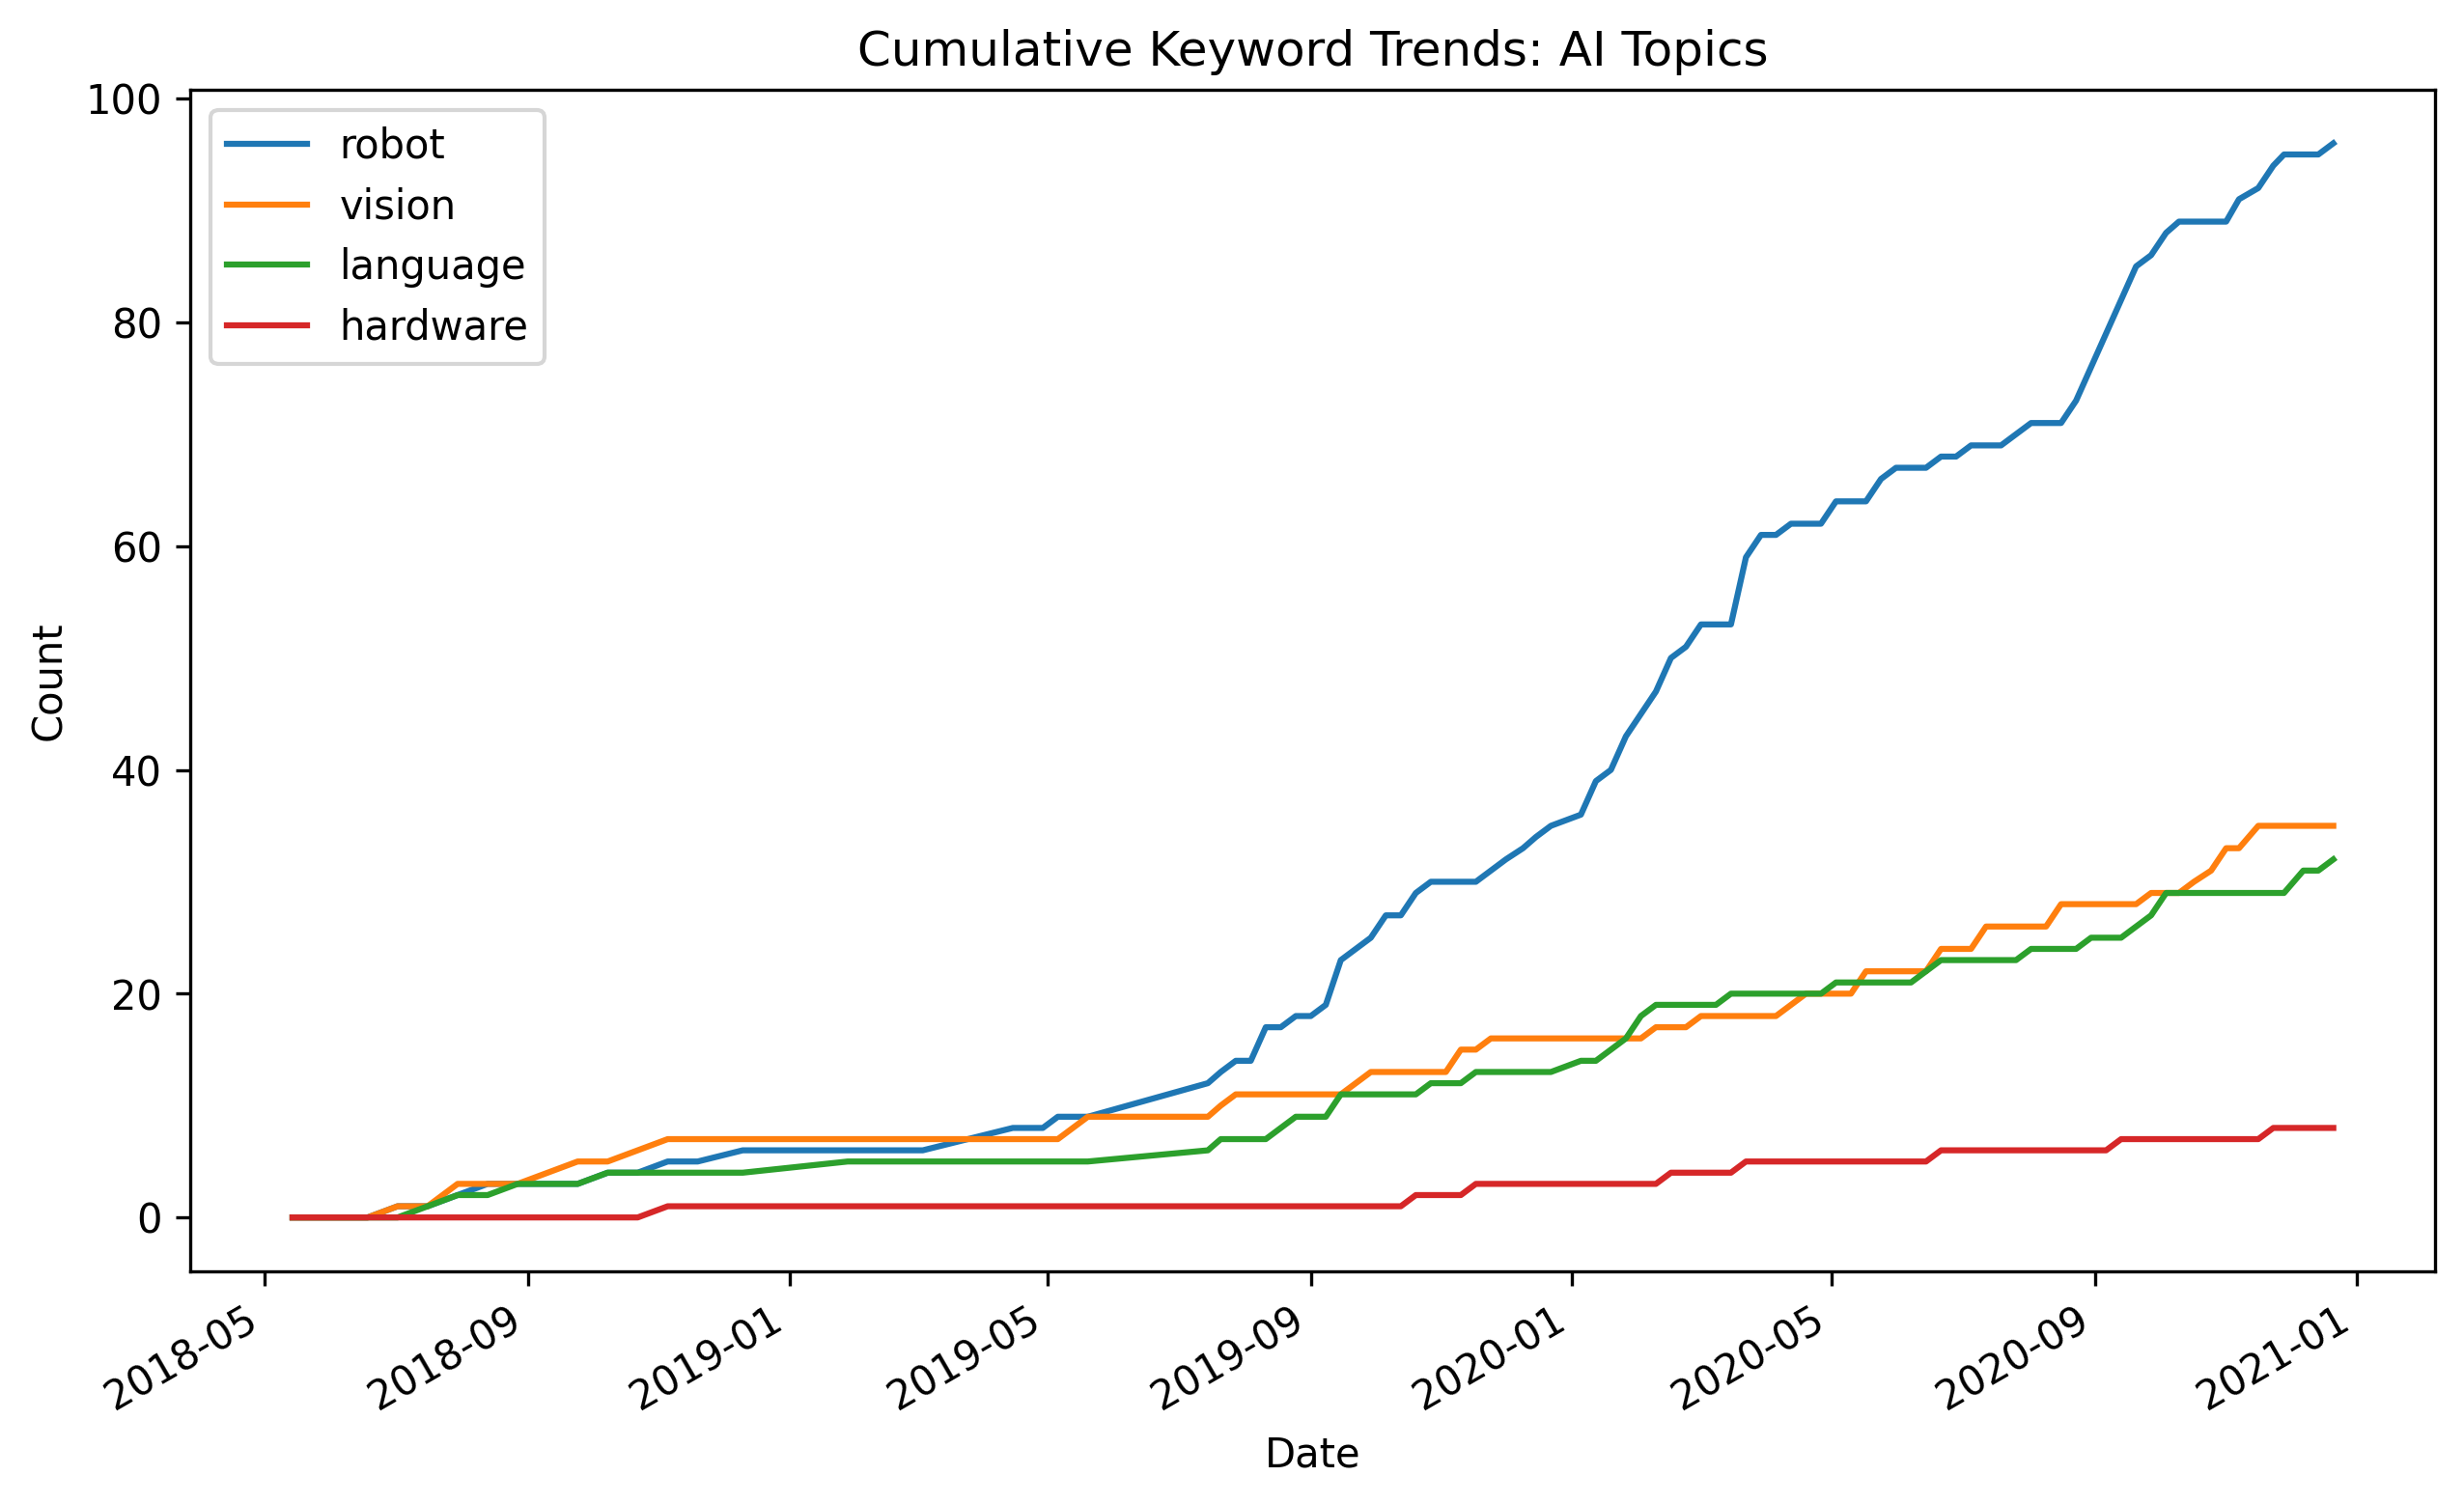

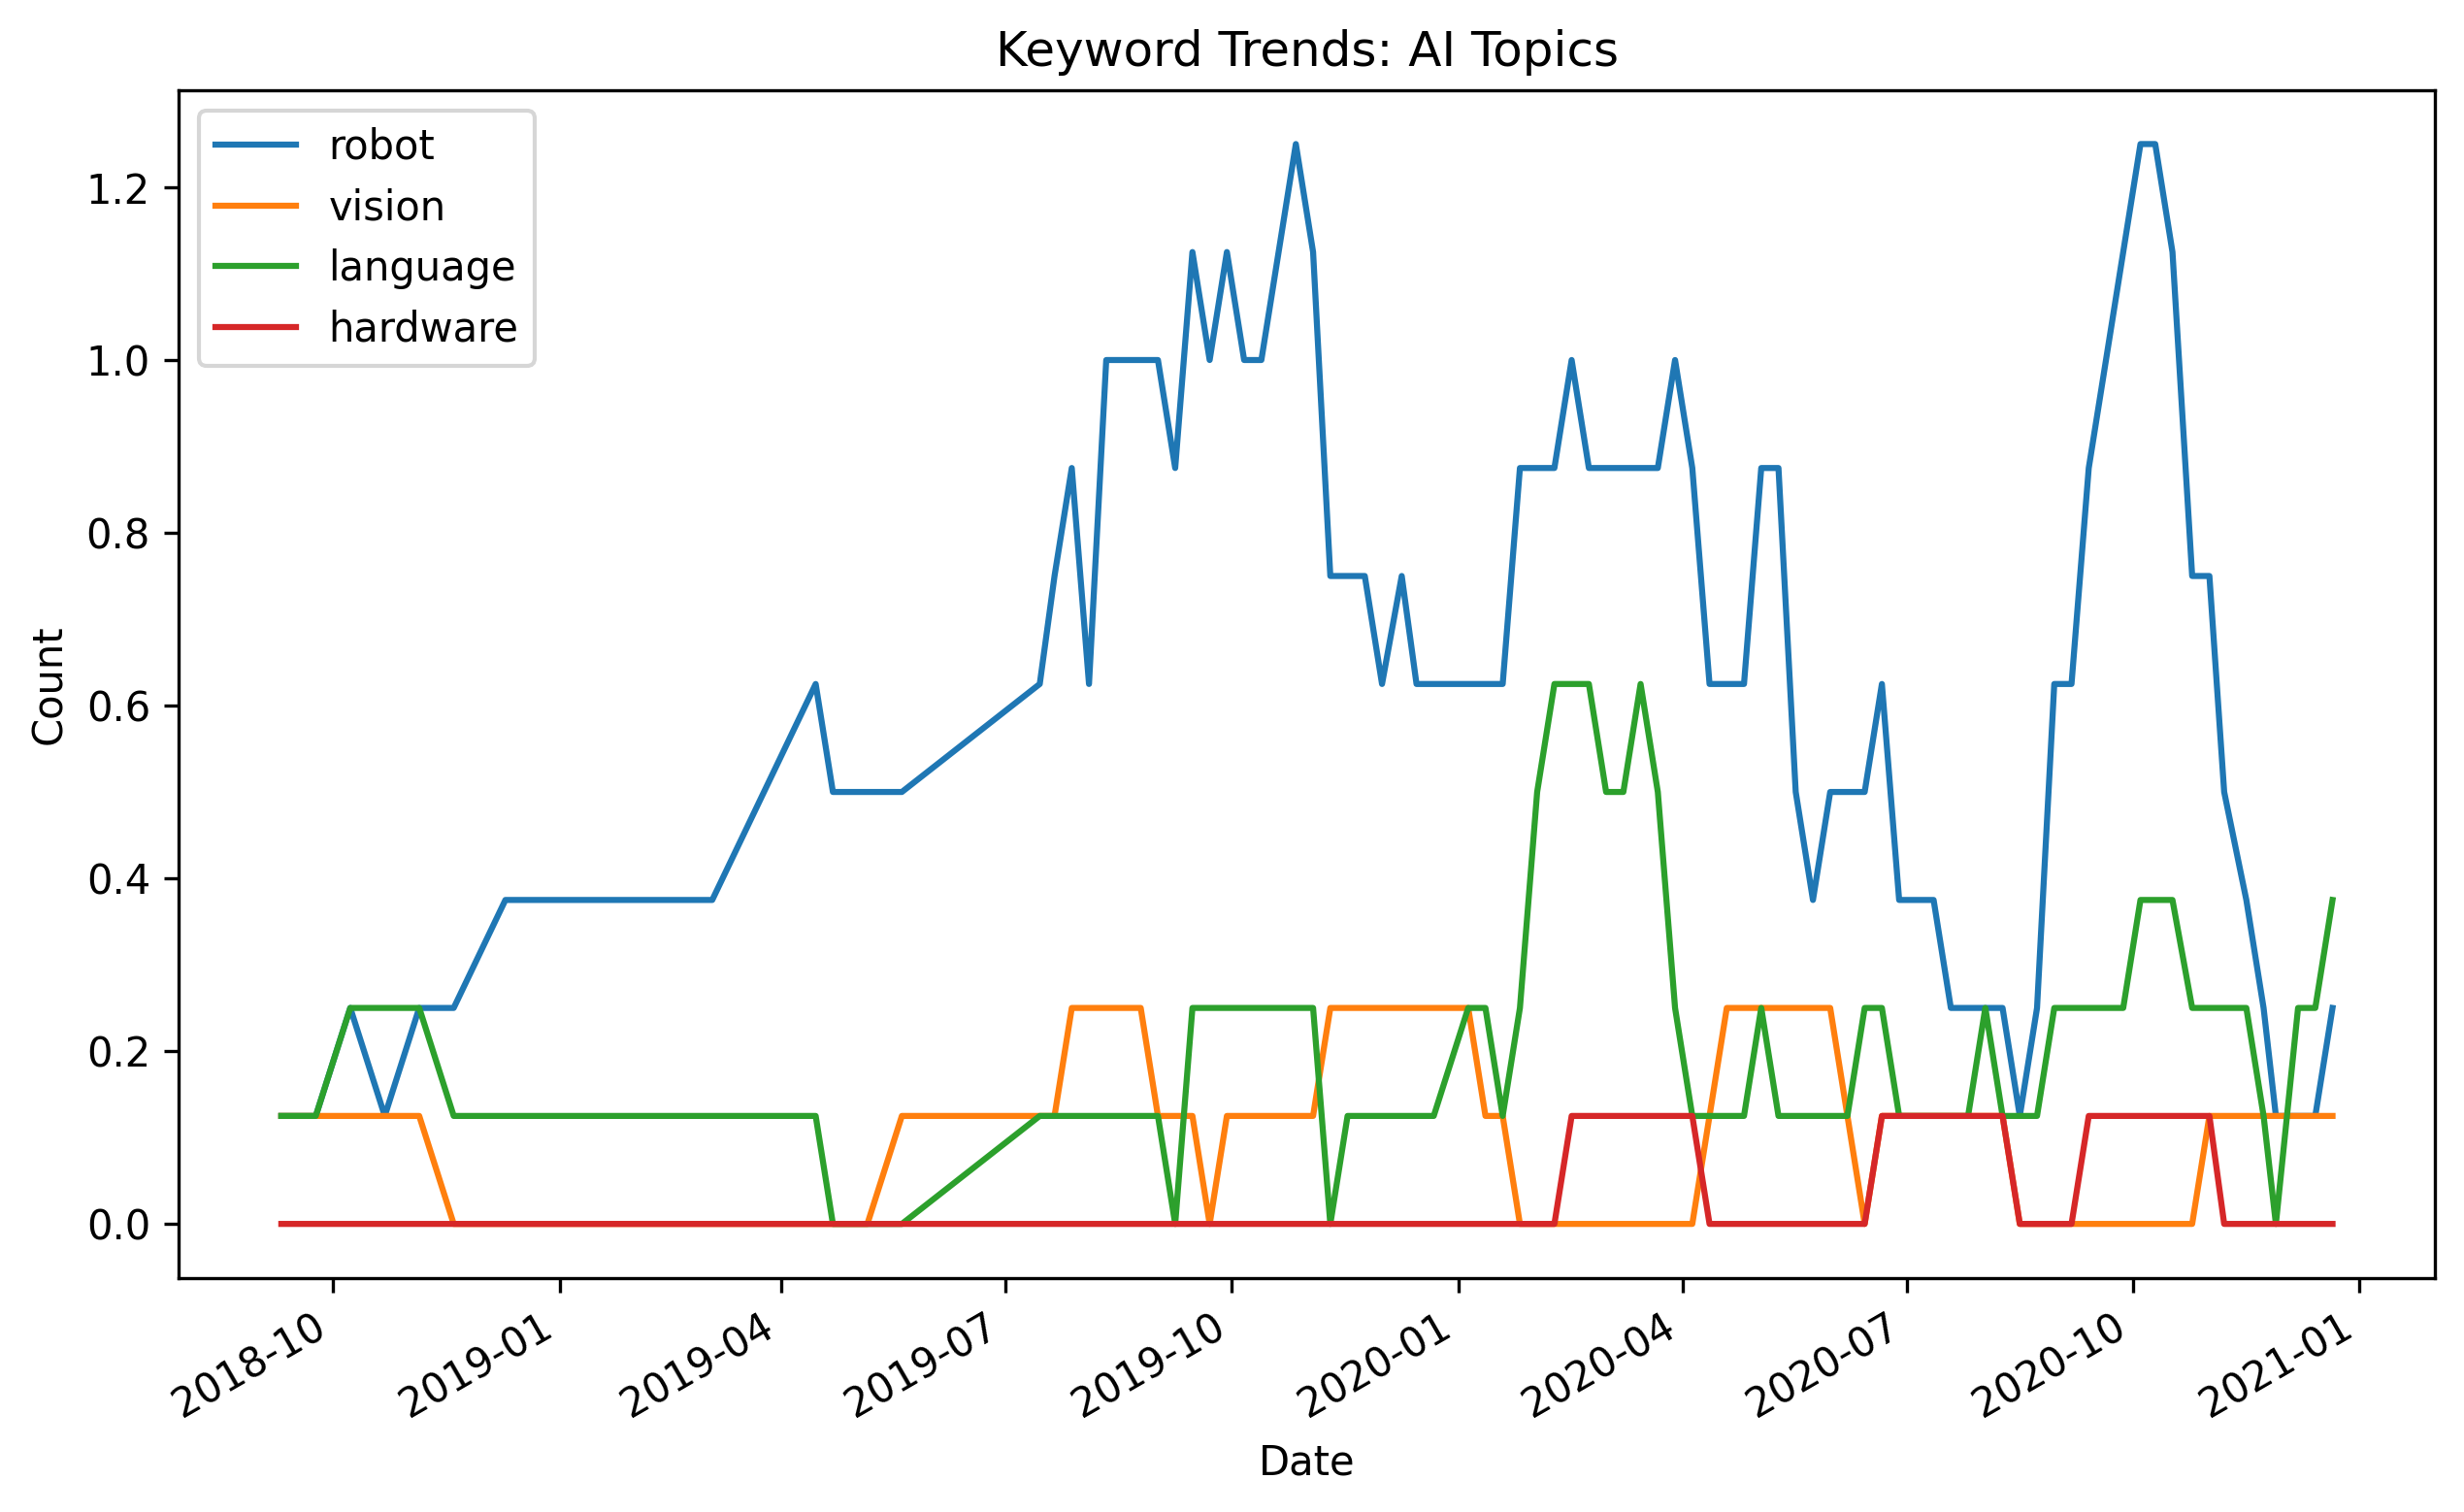

In [145]:
words_synonyms = {    
    'robot': ['robotics'],
    'vision': ['image', 'images', 'cv', 'cnn'],
    'language': ['nlp', 'gpt', 'autocomplete'],
    'hardware': ['chips', 'gpu', 'cpu', 'compute'],
}
    
_ = plot_trends(words_synonyms, display_name='AI Topics', save_name='ai_topics')

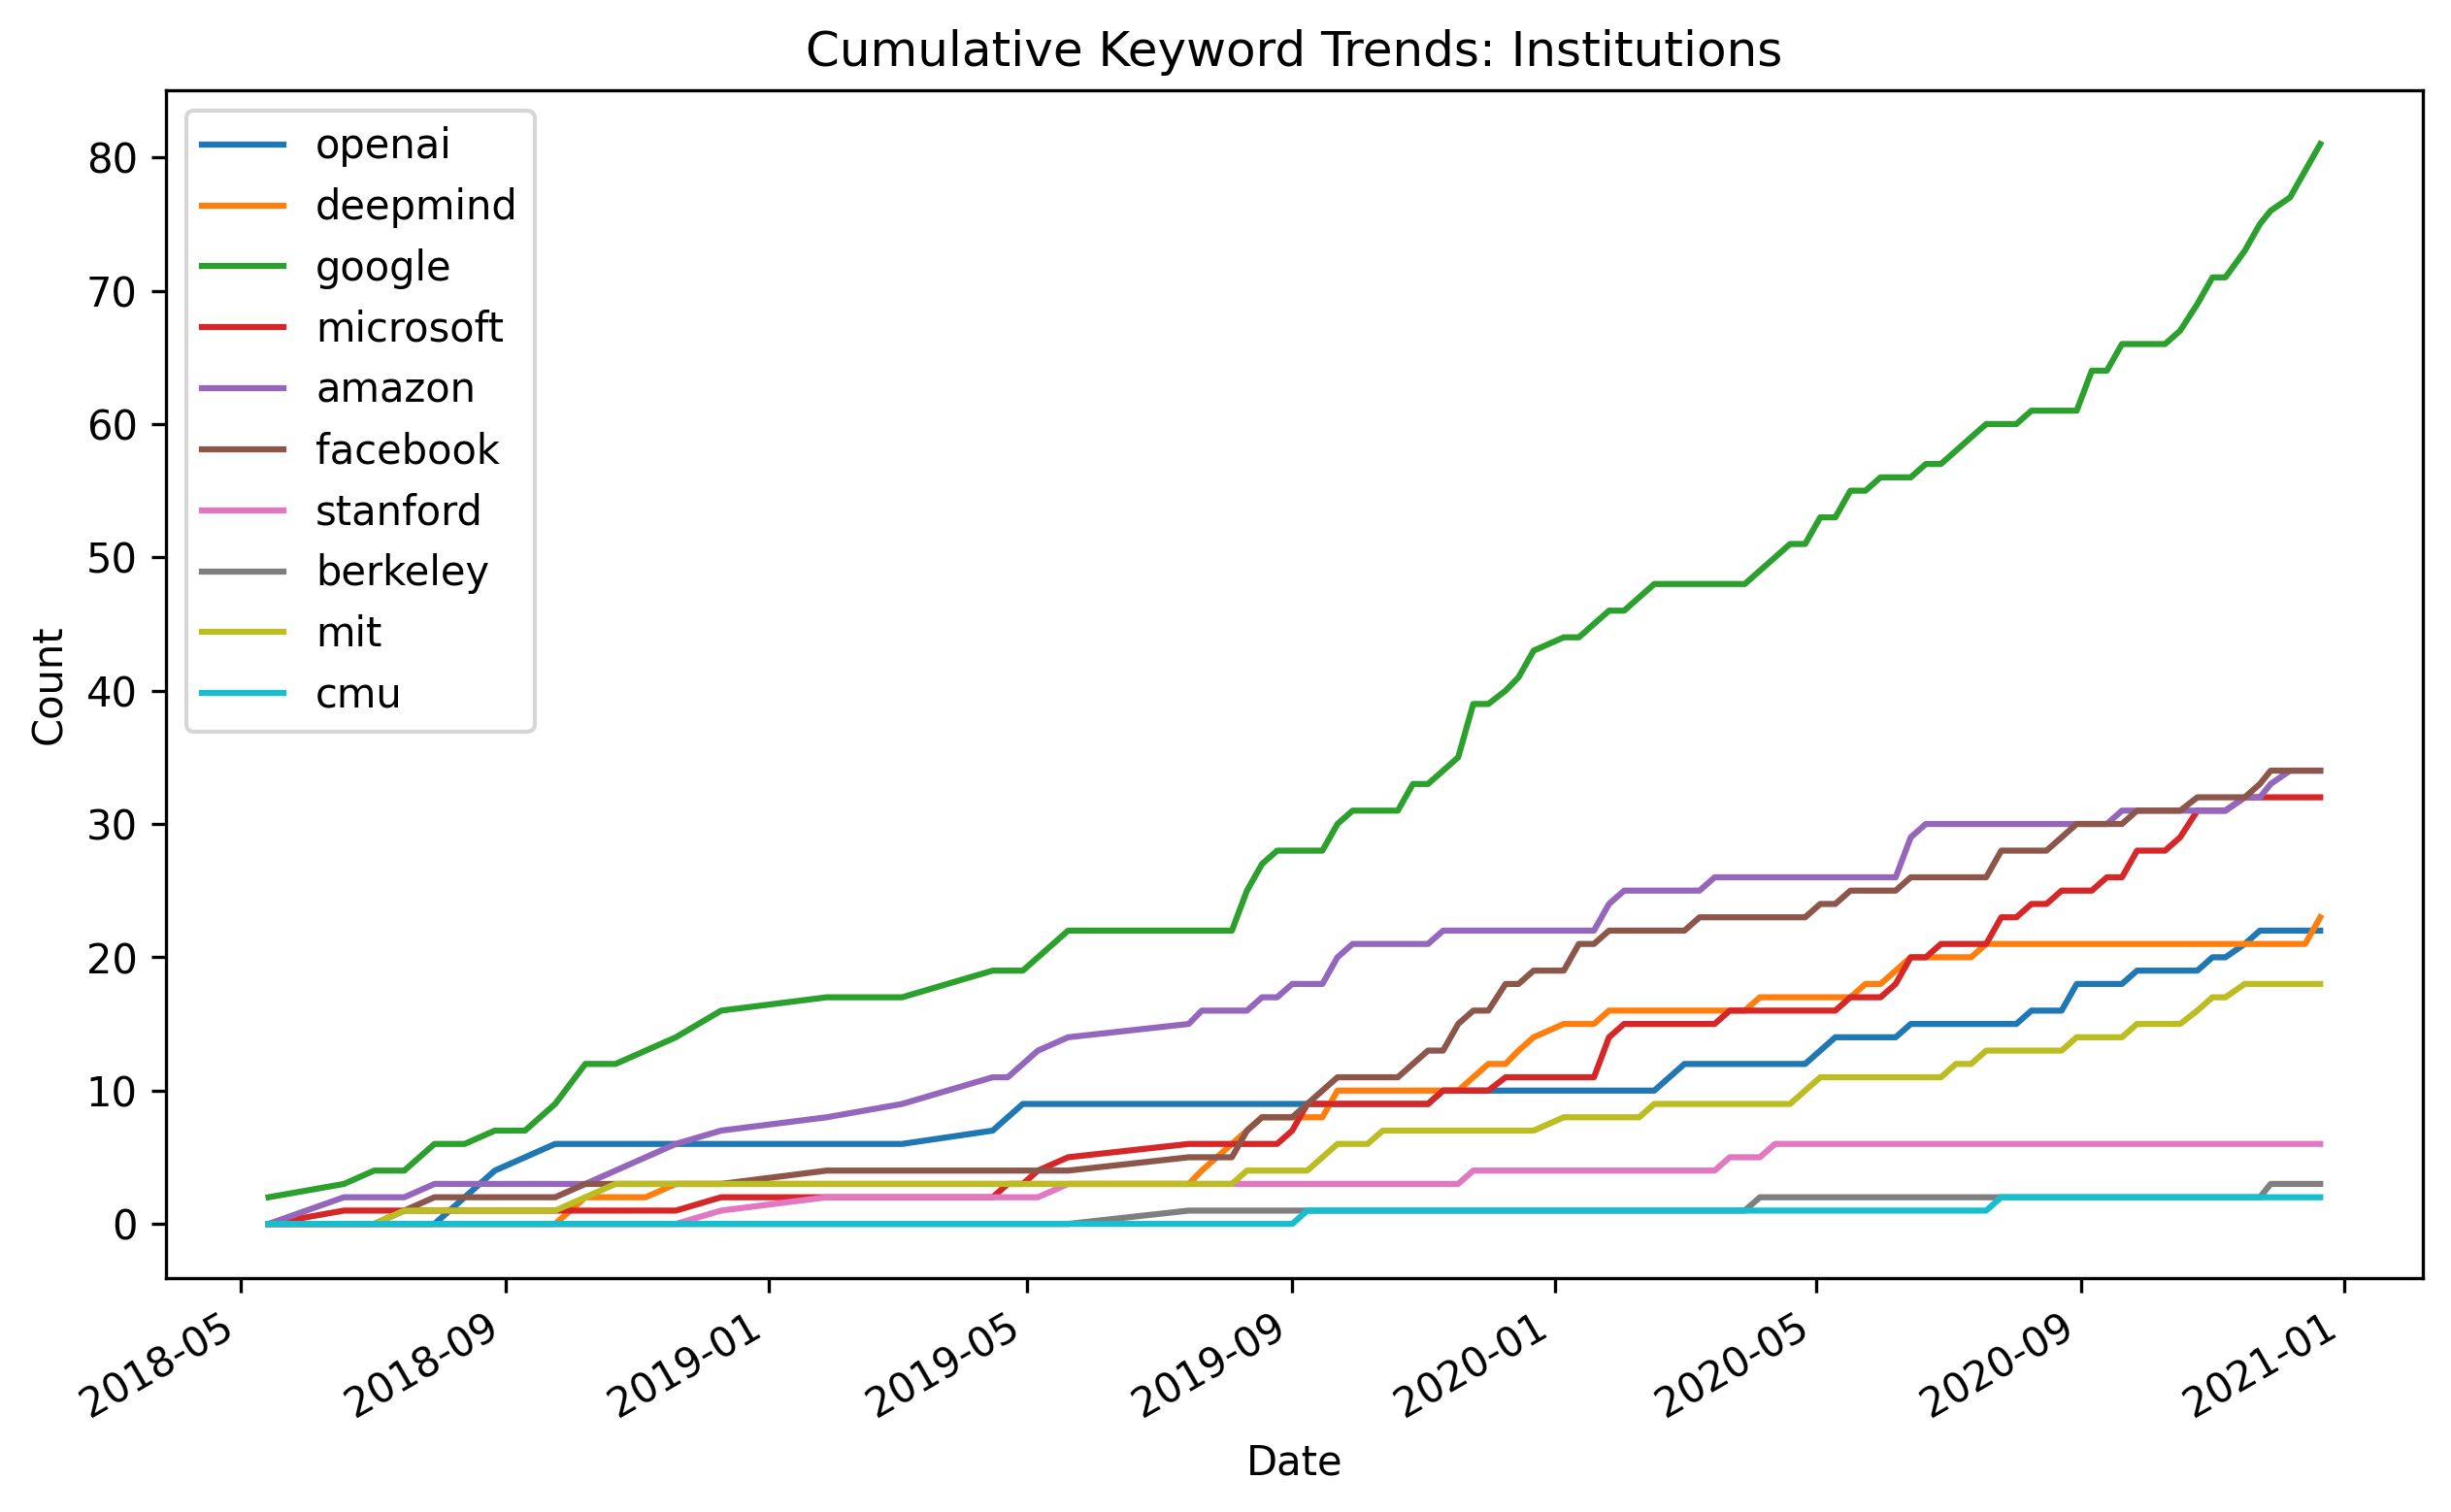

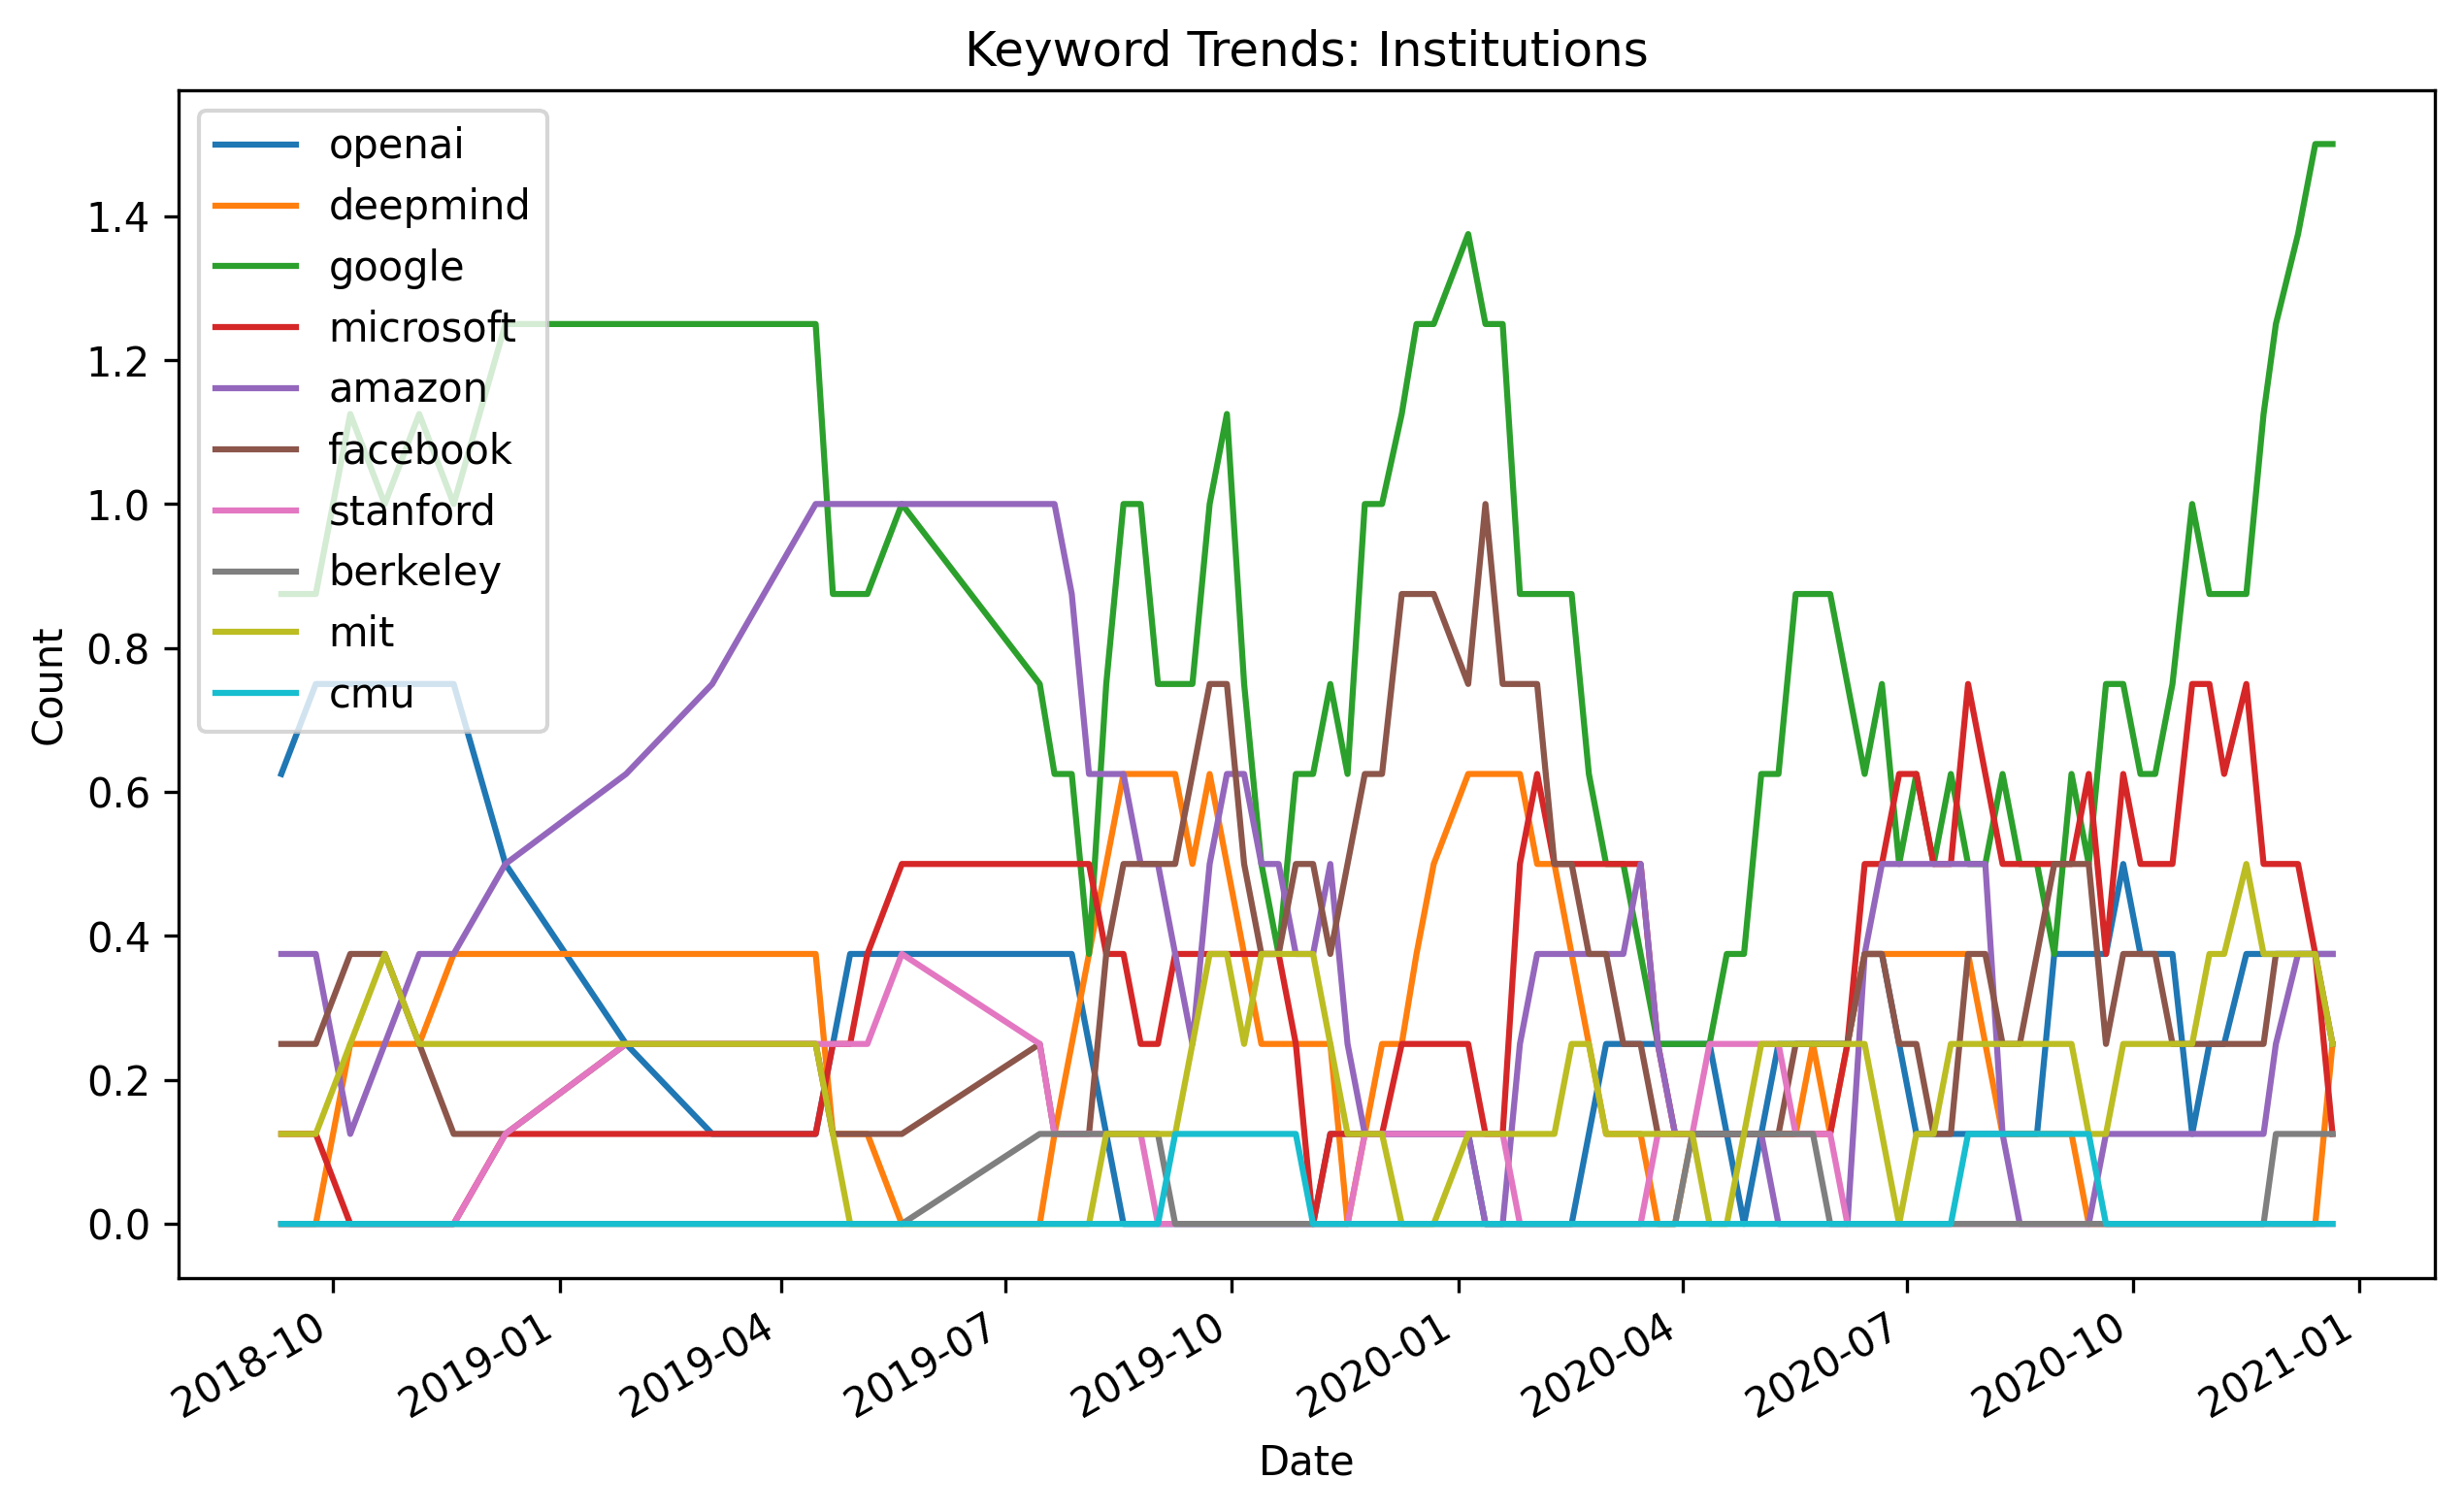

In [146]:
words_synonyms = {k : [] for k in ['openai', 'deepmind', 'google',  'microsoft', 'amazon', 'facebook', 'stanford']}
words_synonyms.update({
    'berkeley': ['ucb'],
    'mit': ['media lab'],
    'cmu': ['carnegie', 'mellon']
})
_ = plot_trends(words_synonyms, display_name='Institutions', save_name='institutions')

In [57]:
df['pca'] = (
   df['title']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
hero.scatterplot(df, 'pca', color='category', title="AI News")

In [60]:
nlp = spacy.load('en')
corpus = st.CorpusFromPandas(df, 
                             category_col='category', 
                             text_col='text',
                             nlp=nlp).build().compact(st.AssociationCompactor(2500))

In [61]:
print('Top common words:')
print(list(corpus.get_scaled_f_scores_vs_background().index[:50]))

Top common words:
['ai', 'openai', 'facebook', 'clearview', 'deepmind', 'twitter', 'deepfakes', 'waymo', 'deepfake', 'neural', 'robots', 'algorithmic', 'imagenet', 'artificial', 'youtube', 'coronavirus', 'algorithms', 'autonomous', 'robotics', 'datasets', 'biases', 'dataset', 'nlp', 'facial', 'buzzfeed', 'adversarial', 'pandemic', 'gans', 'tesla', 'lecun', 'uber', 'driverless', 'researchers', 'dota', 'humans', 'alphago', 'generative', 'drones', 'robot', 'recognition', 'bias', 'reinforcement', 'startups', 'convolutional', 'drone', 'bots', 'robotic', 'intelligence', 'agi', 'musk']


In [72]:
scatter_plots_dir = Path('scatterplots')
if not os.path.isdir(scatter_plots_dir):
    os.makedirs(scatter_plots_dir)

def make_cat_explorer(cat):
    html = st.produce_scattertext_explorer(corpus,
              category=cat,
              category_name=cat,
              not_category_name='Other',
              width_in_pixels=1000,)
    
    with open(scatter_plots_dir / f'{cat} Viz.html', 'wb') as f:
        f.write(html.encode('utf-8'))

In [73]:
for cat in tqdm(categories):
    make_cat_explorer(cat)

In [74]:
def make_word_cloud(cat=None, title='', save_path=None):
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for article in all_articles: 
        if cat is not None and article[0] != cat:
            continue
        val = article[-2]
        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width=800, height=800, 
                    background_color='white', 
                    stopwords=stopwords, 
                    min_font_size=10)\
                .generate(comment_words) 

    # plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None, dpi=300)
    plt.imshow(wordcloud) 
    plt.title(title)
    
    plt.axis("off") 
    plt.tight_layout(pad=0)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show() 

In [75]:
make_word_cloud(None, save_path=plots_dir / 'word_cloud_cat_all.png')

AttributeError: 'float' object has no attribute 'split'